In [27]:
# xG Modeling (NHL) using Logistic Regression 
# goal of an xG-model is to estimate the value of a shot 
# xG of a single shot is the estimated probability of a goal 

# Excluded Empty Net Scnerios For 

# fenwick-based This means that all blocked shots have an xG-value of 0. 
# We only count 
# 1. Goal 
# 2. Shot on Goal 
# 3. Missed Shots 

# Logistic Regression: (use when Dependent Variable is Categorical) 
# Y = Goal 
# Categorical 

# X = 
# Categorical: 
# 1. StrengthState 
# 2. ScoreState  
# 3. LastEvent 
# 4. shotType 
# 5. is_forward 
# 6. is_rebound

# Numerical 
# 1. ShotDistance 
# 2. ShotAngle  

Index(['Season', 'Team', 'Name', 'Logo', 'Color', 'TeamID'], dtype='object')


In [ ]:
# Code Index 

# Block 1: 
# clean and combine datasets for a play by play data with schedule that includes 
# Game Info, Players (who is on the ice), Shot Distance, Shot Angel, Coordinates on Ice 

# Block 2: 
# Prepare Play by Play for Logistic Regression 
# EventID	ShotDistance	ShotAngle	StrengthState	ScoreState	LastEvent	shotType	Goal   is_forward 

# Block 3: 
# Logistic Regression and its assessments 

# Block 4: 
# Compute actual probability for each event 

# Block 5:
# Compute xG for each game 

# Block 6: 
# Team Level Analysis 
# 1. Calculate a team's GF%, xGF%, dGF% 
# 2. Graph xG% vs. GF%  
# 3. Calculate team's xGF, xGA per Game  
# 4. xGF per Game vs. xGA per game analysis 
# 5. Team's Actual GF, GA 

# Block 7: 
# Individual Player Analysis 
# 1. Calculate each player’s xG 
# 2. Graph xG and G by Player
# 3. xG by on ice position graph 
# 4. Graph each player's shot location on ice 

# Block 8: 
# How do we account for shooters' talent? 
# Idea 1: Shooting Percentage:  S% 
# a. Calculate each player’s S% 
# b. Graph overall distribution 
# c. Method of Max Likelihood for Beta Distribution 
# d. Method of Moments 
# e. Two Component Beta Distribution 
# f. Kernel Density Estimate  
# g. Monte-Carlo Simulation for Posterior from Prior  using KDE 
# h. Post Summary Stats 
# i. Forward and Defenceman Distribution 
# Idea 2: Ratio between   Actual Goal:xG     called   Shot Ratio  
# a. Gamma Distribution  
# b. Compute the Posterior for Each Player via Monte Carlo Simulation 
# c. Calculate it against league average  
#.       Shooter Talent = Posterior Shot Ration / League Avg 


In [ ]:
# Model Evaluations: 
# AUC: 0.76 
# Log Loss: 0.21 
# Degrees of Freedom: 30
# p-value (Wilks' Theorm): 0.000000000000001
# Deviance (Full Model): 25575.78390963869
# AIC: 25635.78390963869    

# Variable Significance Level:  (only 3 are significant)  (Wald's Test) 
#                   Feature                    Wald_stat                 p_value
#             ShotDistance        [[1657.272967891452]]                     0.0
#                ShotAngle       [[404.51381715784396]]       5.732538674868002e-90
#             is_rebound       [[59.504200514583054]]         1.2203336986313926e-14 

# Summary Statistics for xG Probability:
# count    82944.000000
# mean         0.067121
# std          0.061545
# min          0.000004
# 25%          0.022119
# 50%          0.049534
# 75%          0.092011
# max          0.625637 

In [ ]:
# After this, I reserached about coming up a variable to Incorporate Shooters Talent 

# Idea 1: 
# Shooting% 
# Goals / Shots 
# Since #of shots taken by each player very different, 
# Tried to utilize Bayesian Stats to get a Posterior Mean for each player 
# Distribution of Shooting Percentage (Players with 25+ Shots) 
# Tried to fit into a Beta Distribution 

# Issues: 
# 1. Shooting% is not really an indicator of how good a shooter is 
#  Defenceman throwing pucks to the net hope for redirect or rebound 
#  Desparation shots by forwards to get a whistle......... 

# 2. The Distribution has multiple peaks, likely due to defenceman and forwards have different shooting% bc dif strategies     

# Idea 2: 
# Ratio bewteen   Actual Goal : xG     called   Shot Ratio  
# Advantage: data is nicely distributed (only count players with 5+ goals) 
# Fitted into a Gamma Distribution and compute the posterior mean using Bayesian Stats 
# Calculate shooter's talent by posterior shot ratio / league average shot ratio 

In [28]:
# Column names for Play by Play csv 

import pandas as pd

df_teams = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/Team2.csv')
print(df_teams.columns) 

play_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/play.csv'
df_play = pd.read_csv(play_fp)
print(df_play.columns) 

Index(['GameID', 'Venue', 'period', 'periodType', 'gameTime', 'StrengthState',
       'Event', 'x', 'y', 'Zone', 'shotType', 'PEN_duration', 'Team', 'Goalie',
       'Player1', 'Player2', 'Player3', 'Corsi', 'Fenwick', 'Shot', 'Goal',
       'EventIndex', 'ShiftIndex', 'ScoreState', 'xG_F', 'xG_S', 'Opponent'],
      dtype='object')


/var/folders/mr/6qm9flxx6yx_m92_zh0gvg_c0000gn/T/ipykernel_48398/1562830229.py:4: DtypeWarning: Columns (1,5,9,10,12,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_play = pd.read_csv(play_fp)


In [29]:
df_schedule = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/schedule.csv')
print(df_schedule.columns)  

Index(['GameDate', 'GameID', 'Season', 'SeasonStage', 'startTimeUTC', 'Team',
       'Opponent', 'Venue', 'GF', 'GA', 'Win', 'Points', 'Game_No', 'B2B',
       'Opp_B2B'],
      dtype='object')


In [30]:
# Block 1:     
# clean and combine datasets for a comprehensive play by play data that includes 
# Game Info, Players (who is on the ice), Shot Distance, Shot Angel, Coordinates on Ice 

# Columns in the play by play data 
# GameID 
# Period 
# GameTime (in seconds) 
# Strength State (5v5, 5v4......) 
# Event: Goal, Shot, Hit, Giveaway, Takeaway...... 
# Zone 
# Players on Ice 
# ScoreState (Score Difference wrt to home team) 

import pandas as pd
import numpy as np
import math

play_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/play.csv' 
schedule_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/schedule.csv'

df_play = pd.read_csv(play_fp)
df_schedule = pd.read_csv(schedule_fp)

# Drop duplicate schedule rows (if any) to ensure one-to-one join on GameID
df_schedule.drop_duplicates(subset=['GameID'], inplace=True)

# Step 2: Prepare Schedule Data and Merge with Play Data
#   - Rename schedule columns  
#       • 'Team' becomes 'SchedTeam'
#       • 'Opponent' becomes 'SchedOpponent'
#       • 'Venue' becomes 'SchedVenue'
#   - Derive HomeTeam and AwayTeam:
#       If SchedVenue == 'Home' then HomeTeam = SchedTeam, AwayTeam = SchedOpponent;
#       else vice versa.
#   - Merge the play events with schedule on GameID.
df_schedule.rename(columns={
    'Team': 'SchedTeam',
    'Opponent': 'SchedOpponent',
    'Venue': 'SchedVenue'
}, inplace=True)

# Derive HomeTeam and AwayTeam based on the scheduled venue:
df_schedule['HomeTeam'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                   df_schedule['SchedTeam'],
                                   df_schedule['SchedOpponent'])
df_schedule['AwayTeam'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                   df_schedule['SchedOpponent'],
                                   df_schedule['SchedTeam'])

# Merge play events with schedule info on GameID (each event gets the game-level info)
df_merged = pd.merge(df_play, df_schedule, on='GameID', how='left')

# Step 3: Build the Intermediate Table (pbp_temp1)
#   - Set Season from schedule  
#   - Compute gameDate as the first 10 characters of GameDate.
#   - Use the play file’s Team as EventTeam (coalesce to an empty string if missing).
#   - Use the play file’s period.
#   - Recompute Venue by comparing the first three letters 
#     of EventTeam to HomeTeam and AwayTeam.
#   - Bring through additional fields.
#   - Rename x and y to xCoord and yCoord.
df_temp1 = pd.DataFrame()

# Basic fields from schedule and play:
df_temp1['GameID'] = df_merged['GameID']
df_temp1['Season'] = df_merged['Season']  # from schedule
df_temp1['HomeTeam'] = df_merged['HomeTeam']
df_temp1['AwayTeam'] = df_merged['AwayTeam']
df_temp1['gameDate'] = df_merged['GameDate'].astype(str).str[:10]

# EventTeam from play (if missing, use empty string)
df_temp1['EventTeam'] = df_merged['Team'].fillna('')

# Use period from play
df_temp1['Period'] = df_merged['period']

# Determine event Venue: if the first three letters of EventTeam match HomeTeam then 'Home',
# if they match AwayTeam then 'Away', else leave as empty string.
df_temp1['Venue'] = np.where(
    df_temp1['EventTeam'].str[:3] == df_temp1['HomeTeam'].str[:3],
    'Home',
    np.where(
        df_temp1['EventTeam'].str[:3] == df_temp1['AwayTeam'].str[:3],
        'Away',
        ''
    )
)

# Bring through other fields from play:
df_temp1['GameTime'] = df_merged['gameTime']
df_temp1['SeasonStage'] = df_merged['SeasonStage'].fillna('')
df_temp1['StrengthState'] = df_merged['StrengthState']  # initial value from play; will be recalculated below
df_temp1['Event'] = df_merged['Event']
df_temp1['sortOrder'] = df_merged['EventIndex']  # using EventIndex for ordering

# Rename x and y to xCoord and yCoord
df_temp1['xCoord'] = df_merged['x']
df_temp1['yCoord'] = df_merged['y']

df_temp1['shotType'] = df_merged['shotType']
df_temp1['PIM'] = df_merged['PEN_duration']
df_temp1['Goalie'] = df_merged['Goalie']
df_temp1['Player1'] = df_merged['Player1']
df_temp1['Player2'] = df_merged['Player2']
df_temp1['Player3'] = df_merged['Player3']

# Bring through event indicators from play:
df_temp1['Goal'] = df_merged['Goal']
df_temp1['Shot'] = df_merged['Shot']
df_temp1['Fenwick'] = df_merged['Fenwick']
df_temp1['Corsi'] = df_merged['Corsi']

# Order events by GameID and sortOrder (as in SQL)
df_temp1.sort_values(by=['GameID', 'sortOrder'], inplace=True)

# Step 4: Create the Second Intermediate Table (pbp_temp2)
#   - Recalculate StrengthState based on situationCode and Venue.
#   - Compute adjusted coordinates (X and Y) based on Venue and homeTeamDefendingSide.
#   - Compute binary event indicators (Goal, Shot, Fenwick, Corsi) based on Event. 

# Fenwick: shot attempt differential while playing at even strength. 
#.         also known as unblocked shot attempts by the NHL 
df_temp2 = df_temp1.copy()


# For adjusted coordinates, if no adjustment is needed, we set:
df_temp2['X'] = df_temp2['xCoord']
df_temp2['Y'] = df_temp2['yCoord']

# Definitions of terms 
df_temp2['Goal'] = np.where(df_temp2['Event'] == 'goal', 1, 0)
df_temp2['Shot'] = np.where(df_temp2['Event'].isin(['goal', 'shot-on-goal']), 1, 0)
df_temp2['Fenwick'] = np.where(df_temp2['Event'].isin(['goal', 'shot-on-goal', 'missed-shot']), 1, 0)
df_temp2['Corsi'] = np.where(df_temp2['Event'].isin(['goal', 'shot-on-goal', 'missed-shot', 'blocked-shot']), 1, 0)


# Step 5: Create the Final Adjusted Table (pbp_adjusted)
#   - Compute a unique EventID per game (GameID*10000 + row_number).
#   - Compute Zone based on adjusted X coordinate.
#   - Compute ScoreState using running totals of Goal.
#   - Determine LastEvent (lag of Event) and TSLE (time since last event).
#   - Compute ShotDistance and ShotAngle for events marked as Fenwick.
df_adjusted = df_temp2.copy()


# (a) Compute row number per GameID and unique EventID:
df_adjusted['row_number'] = df_adjusted.groupby('GameID').cumcount() + 1
df_adjusted['EventID'] = df_adjusted['GameID'] * 10000 + df_adjusted['row_number']


# (b) Compute Zone based on X:
df_adjusted['Zone'] = np.where(
    df_adjusted['X'] <= -25, 'Def',
    np.where(df_adjusted['X'] < 25, 'Neu',
             np.where(df_adjusted['X'] >= 25, 'Off', ''))
)


# (c) ScoreState 
# ScoreState = (Goals for team up to that event * 2) - (Total goals in game up to that event) - (Current goal event indicator)  
# A positive ScoreState suggests that the team has a scoring advantage.
df_adjusted['cumsum_venue'] = df_adjusted.groupby(['GameID', 'Venue'])['Goal'].cumsum()
df_adjusted['cumsum_game']  = df_adjusted.groupby('GameID')['Goal'].cumsum()
df_adjusted['ScoreState'] = df_adjusted['cumsum_venue'] * 2 - df_adjusted['cumsum_game'] - df_adjusted['Goal']


# (d) Determine LastEvent 
df_adjusted['LastEvent'] = df_adjusted.groupby('GameID')['Event'].shift(1).fillna('')


# (e) Calculate TSLE (Time Since Last Event) as the difference in GameTime.
df_adjusted['TSLE'] = df_adjusted.groupby('GameID')['GameTime'].diff().fillna(0)


# (f) For Fenwick events, calculate 
# 1. ShotDistance: straight-line distance  
# 2. ShotAngle: arctangent function 

df_adjusted['ShotDistance'] = np.where(
    df_adjusted['Fenwick'] == 1,
    np.sqrt((df_adjusted['X'] - 89)**2 + (df_adjusted['Y'])**2),
    ''
)
df_adjusted['ShotAngle'] = np.where(
    df_adjusted['Fenwick'] == 1,
    np.abs(np.degrees(np.arctan2(df_adjusted['Y'], 89 - df_adjusted['X']))),
    ''
)

df_adjusted['is_rebound'] = np.where(
    (df_adjusted['LastEvent'] == 'shot-on-goal') & (df_adjusted['TSLE'] <= 2),
    1,
    0
)

# (g) Drop helper columns used for calculations.
df_adjusted.drop(columns=['cumsum_venue', 'cumsum_game', 'row_number'], inplace=True, errors='ignore')

# (h) Finally, sort the adjusted DataFrame by GameID and sortOrder.
df_adjusted.sort_values(by=['GameID', 'sortOrder'], inplace=True)


# Step 6: Export the Final Adjusted Data to CSV
output_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/pbp_adjusted.csv'
df_adjusted.to_csv(output_fp, index=False)

print("Export complete: pbp_adjusted.csv has been saved.")


/var/folders/mr/6qm9flxx6yx_m92_zh0gvg_c0000gn/T/ipykernel_48398/1163735511.py:11: DtypeWarning: Columns (1,5,9,10,12,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_play = pd.read_csv(play_fp)


Export complete: pbp_adjusted.csv has been saved.


In [31]:
play_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/pbp_adjusted.csv'
df_play = pd.read_csv(play_fp)
print(df_play.columns)  

Index(['GameID', 'Season', 'HomeTeam', 'AwayTeam', 'gameDate', 'EventTeam',
       'Period', 'Venue', 'GameTime', 'SeasonStage', 'StrengthState', 'Event',
       'sortOrder', 'xCoord', 'yCoord', 'shotType', 'PIM', 'Goalie', 'Player1',
       'Player2', 'Player3', 'Goal', 'Shot', 'Fenwick', 'Corsi', 'X', 'Y',
       'EventID', 'Zone', 'ScoreState', 'LastEvent', 'TSLE', 'ShotDistance',
       'ShotAngle', 'is_rebound'],
      dtype='object')


In [32]:
# Load the play-by-play data from pbp_adjusted.csv
play_fp = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/pbp_adjusted.csv')

# Filter the DataFrame for rows where Fenwick equals 1
fenwick_events = play_fp[play_fp['Fenwick'] == 1]

# Get unique event types from the 'Event' column for the filtered data
unique_fenwick_events = fenwick_events['Event'].unique()

# Print the unique event types
print("Unique event types when Fenwick == 1:")
print(unique_fenwick_events)


Unique event types when Fenwick == 1:
['shot-on-goal' 'missed-shot' 'goal']


In [33]:
# Block 2: 
# Prepare Play by Play for Logistic Regression 
# EventID	ShotDistance	ShotAngle	StrengthState	ScoreState	LastEvent	shotType	Goal    

import pandas as pd
import numpy as np

input_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/pbp_adjusted.csv'
df = pd.read_csv(input_fp)

# 2. Filter Rows
# Keep only rows where Fenwick == 1 AND
# StrengthState not in ['ENA', '', '1v0']
df = df[
    (df['Fenwick'] == 1) &
    (df['StrengthState'] != 'ENA') &
    (df['StrengthState'] != '') &
    (df['StrengthState'] != '1v0')
]


# 3. Final Transformations

#a. define strength state 
conditions = [
    df['StrengthState'] == '5v5',
    df['StrengthState'].isin(['4v4', '3v3']),
    df['StrengthState'].isin(['5v4', 'ENF']),
    df['StrengthState'].isin(['4v3', '5v3']),
    df['StrengthState'].isin(['4v5', '3v4', '3v5'])
]

choices = ['EV1', 'EV2', 'PP1', 'PP2', 'SH']

df['StrengthState'] = np.select(conditions, choices, default=df['StrengthState'])

# b. Create a row number within each GameID and compute a unique EventID
df['row_number'] = df.groupby('GameID').cumcount() + 1
df['EventID'] = df['GameID'] * 10000 + df['row_number']

# c. Compute Zone based on xCoord
df['Zone'] = np.where(
    df['xCoord'] <= -25, 'Def',
    np.where(
        (df['xCoord'] > -25) & (df['xCoord'] < 25),
        'Neu',
        np.where(df['xCoord'] >= 25, 'Off', '')
    )
)

# d. Compute ScoreState  
df['ScoreState'] = np.where(
    df['ScoreState'] < -2, '<-2',
    np.where(df['ScoreState'] > 2, '>2', df['ScoreState'])
) 

# e. Previous event as LastEvent
df['LastEvent'] = np.where(
    df['TSLE'] > 3,
    'No',
    np.where(
        df['LastEvent'].isin([
            'giveaway',
            'takeaway',
            'shot-on-goal',
            'missed-shot',
            'blocked-shot',
            'failed-shot-attempt'
        ]),
        'Shot',
        'Other'
    )
)

# f. Time Since Last Event (TSLE)
df['TSLE'] = df.groupby('GameID')['GameTime'].diff().fillna(0)

# g. ShotDistance & ShotAngle
df['ShotDistance'] = np.where(
    df['Fenwick'] == 1,
    np.sqrt((df['xCoord'] - 89)**2 + (df['yCoord'])**2),
    ''
)
df['ShotAngle'] = np.where(
    df['Fenwick'] == 1,
    np.abs(np.degrees(np.arctan2(df['yCoord'], 89 - df['xCoord']))),
    ''
)

# h. shot type 
df['ShotType'] = np.where(
    df['shotType'].isin(['bat', 'between-legs', 'poke', 'cradle', '']),
    'Other',
    df['shotType']
) 

 
# i. Drop helper columns
df.drop(columns=['row_number', 'cumsum_venue', 'cumsum_game'], inplace=True, errors='ignore')

# j. Sort by GameID and sortOrder
df.sort_values(by=['GameID', 'sortOrder'], inplace=True)


# 4. Select Only the Desired Columns & Export
columns_needed = [
    'EventID',
    'EventTeam', 
    'ShotDistance',
    'ShotAngle',
    'X',
    'Y', 
    'StrengthState',
    'ScoreState',
    'LastEvent',
    'shotType',
    'Player1', 
    'Event', 
    'TSLE', 
    'is_rebound', 
    'Goal'
]
df_final = df[columns_needed]

output_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/xgmodel.csv'
df_final.to_csv(output_fp, index=False)

print("Export complete: xgmodel.csv has been saved with the filtered rows and requested columns.")


Export complete: xgmodel.csv has been saved with the filtered rows and requested columns.


In [34]:
# Update with is_forward column 
# 1 if shot taker is forward 
# 0 if not 

df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xgmodel.csv')
df_players = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')

# Step 1: Merge the xG DataFrame with the players DataFrame
# Matching 'Player1' from xG with 'playerId' from players
df_merged = pd.merge(df_xg, df_players[['playerId', 'Position']], 
                     left_on='Player1', right_on='playerId', how='left')

# Step 2: Create the new column 'is_forward'
df_merged['is_forward'] = np.where(df_merged['Position'] == 'F', 1, 0)

# Step 3: Print out a sample 
print(df_merged.head())

output_path = '/Users/meiza/Desktop/NHL Modeling/xG Model/xgmodel.csv'
df_merged.to_csv(output_path, index=False)
print(f"Export complete: {output_path}")

          EventID EventTeam  ShotDistance  ShotAngle     X     Y  \
0  20240200010001       NJD     51.224994  51.340192  57.0 -40.0   
1  20240200010002       NJD     33.286634  57.264774  71.0 -28.0   
2  20240200010003       NJD     47.507894  30.343249  48.0 -24.0   
3  20240200010004       BUF     57.140179  32.855722  41.0  31.0   
4  20240200010005       BUF     55.081757  15.802514  36.0 -15.0   

  StrengthState ScoreState LastEvent shotType  Player1         Event  TSLE  \
0           EV1          0     Other    wrist  8483495  shot-on-goal   0.0   
1           EV1          0        No    wrist  8479407   missed-shot  21.0   
2           EV1          0        No     slap  8476462  shot-on-goal  11.0   
3           EV1          0        No    wrist  8482175  shot-on-goal  22.0   
4           EV1          0     Other     slap  8482671   missed-shot   4.0   

   is_rebound  Goal  playerId Position  is_forward  
0           0     0   8483495        D           0  
1           0   

In [3]:
# Block 3: 
# Logistic Regression 
# Use when y is catrgorical 
# y = goal 

import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import log_loss 

In [4]:
df = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xgmodel.csv')
print(df.columns) 
df

Index(['EventID', 'EventTeam', 'ShotDistance', 'ShotAngle', 'X', 'Y',
       'StrengthState', 'ScoreState', 'LastEvent', 'shotType', 'Player1',
       'Event', 'TSLE', 'is_rebound', 'Goal', 'playerId', 'Position',
       'is_forward'],
      dtype='object')


,EventID,EventTeam,ShotDistance,ShotAngle,X,Y,StrengthState,ScoreState,LastEvent,shotType,Player1,Event,TSLE,is_rebound,Goal,playerId,Position,is_forward
0,20240200010001,NJD,51.224994,51.340192,57.0,-40.0,EV1,0,Other,wrist,8483495,shot-on-goal,0.0,0,0,8483495,D,0
1,20240200010002,NJD,33.286634,57.264774,71.0,-28.0,EV1,0,No,wrist,8479407,missed-shot,21.0,0,0,8479407,F,1
2,20240200010003,NJD,47.507894,30.343249,48.0,-24.0,EV1,0,No,slap,8476462,shot-on-goal,11.0,0,0,8476462,D,0
3,20240200010004,BUF,57.140179,32.855722,41.0,31.0,EV1,0,No,wrist,8482175,shot-on-goal,22.0,0,0,8482175,F,1
4,20240200010005,BUF,55.081757,15.802514,36.0,-15.0,EV1,0,Other,slap,8482671,missed-shot,4.0,0,0,8482671,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82939,20240209660082,NJD,165.680415,5.194429,-76.0,-15.0,SH,-2,No,snap,8477508,shot-on-goal,37.0,0,0,8477508,F,1
82940,20240209660083,VGK,46.010868,1.245364,43.0,1.0,PP1,2,No,slap,8478396,shot-on-goal,21.0,0,0,8478396,D,0
82941,20240209660084,NJD,22.203603,35.837653,71.0,13.0,SH,-2,No,snap,8480002,shot-on-goal,9.0,0,0,8480002,F,1
82942,20240209660085,NJD,13.000000,22.619865,77.0,-5.0,SH,-2,Shot,backhand,8475455,missed-shot,1.0,1,0,8475455,D,0


In [5]:
y = df["Goal"] 
y

0        0
1        0
2        0
3        0
4        0
        ..
82939    0
82940    0
82941    0
82942    0
82943    0
Name: Goal, Length: 82944, dtype: int64

In [6]:
X1 = df[["StrengthState","ScoreState", "LastEvent", "shotType", 'is_forward','is_rebound']]
X1

,StrengthState,ScoreState,LastEvent,shotType,is_forward,is_rebound
0,EV1,0,Other,wrist,0,0
1,EV1,0,No,wrist,1,0
2,EV1,0,No,slap,0,0
3,EV1,0,No,wrist,1,0
4,EV1,0,Other,slap,0,0
...,...,...,...,...,...,...
82939,SH,-2,No,snap,1,0
82940,PP1,2,No,slap,0,0
82941,SH,-2,No,snap,1,0
82942,SH,-2,Shot,backhand,0,1


In [7]:
X2 = df[["ShotDistance","ShotAngle"]] 
X2

,ShotDistance,ShotAngle
0,51.224994,51.340192
1,33.286634,57.264774
2,47.507894,30.343249
3,57.140179,32.855722
4,55.081757,15.802514
...,...,...
82939,165.680415,5.194429
82940,46.010868,1.245364
82941,22.203603,35.837653
82942,13.000000,22.619865


In [8]:
X1 = pd.get_dummies(X1) 
X1 = X1.astype(int) 
X1

,is_forward,is_rebound,StrengthState_EV1,StrengthState_EV2,StrengthState_PP1,StrengthState_PP2,StrengthState_SH,ScoreState_-1,ScoreState_-2,ScoreState_0,...,shotType_bat,shotType_between-legs,shotType_cradle,shotType_deflected,shotType_poke,shotType_slap,shotType_snap,shotType_tip-in,shotType_wrap-around,shotType_wrist
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82939,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
82940,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
82941,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
82942,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X = X2.join(X1) 
X 

,ShotDistance,ShotAngle,is_forward,is_rebound,StrengthState_EV1,StrengthState_EV2,StrengthState_PP1,StrengthState_PP2,StrengthState_SH,ScoreState_-1,...,shotType_bat,shotType_between-legs,shotType_cradle,shotType_deflected,shotType_poke,shotType_slap,shotType_snap,shotType_tip-in,shotType_wrap-around,shotType_wrist
0,51.224994,51.340192,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,33.286634,57.264774,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,47.507894,30.343249,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,57.140179,32.855722,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,55.081757,15.802514,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82939,165.680415,5.194429,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
82940,46.010868,1.245364,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
82941,22.203603,35.837653,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
82942,13.000000,22.619865,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3) 

In [11]:
# a logistic regression two parameters:
# max_iter: max number of iterations the solver will use to converge        
# fit_intercept=False: This tells the model not to calculate an intercept term                    
log_reg = LogisticRegression(max_iter=6000, fit_intercept=False).fit(X_train, y_train)  

In [12]:
# Predict probabilities on the training set (column [:,1] is the probability of class "1")
prob = log_reg.predict_proba(X_test)[:, 1]
y_test = y_test.tolist()  # Convert y_test to a Python list

In [13]:
# (Likewise) predict probabilities on the training set, store them in 'prob_train'
prob_train = log_reg.predict_proba(X_train)[:, 1]
y_train = y_train.tolist()  # Convert y_train to a Python list 

In [14]:
# Create a DataFrame to store probabilities and actual goals
test = pd.DataFrame()
test['prob'] = pd.DataFrame(prob.tolist())  # or prob.tolist() if you prefer
test['Goal'] = pd.DataFrame(y_test)
test 

,prob,Goal
0,0.000016,0
1,0.205311,0
2,0.072565,0
3,0.047485,1
4,0.010815,0
...,...,...
24879,0.028049,1
24880,0.034796,0
24881,0.057519,1
24882,0.013934,0


In [15]:
test2 = pd.DataFrame() 
test2['prob'] = pd.DataFrame(prob_train.tolist())
test2['Goal'] = pd.DataFrame(y_train) 
test2 

,prob,Goal
0,0.007905,0
1,0.051506,0
2,0.059284,0
3,0.062130,0
4,0.020802,0
...,...,...
58055,0.208274,0
58056,0.053620,1
58057,0.081898,0
58058,0.023033,0


In [16]:
# Area Under Curve 
# Receiver operating characteristic
# the sensitivity as a function of false positive rate. (Type I Error) 

# it means that 76% of the time, the model will assign a higher probability to a positive example than to a negative one 

AUC = roc_auc_score(y_test, prob) 
AUC 

np.float64(0.7542145658503869)

In [17]:
AUC2 = roc_auc_score(y_train, prob_train) 
AUC2 

np.float64(0.7609031708954385)

In [18]:
# Calculate log loss on the first set 
# how close the predicted probabilities are to the true class labels 
# A smaller log loss value indicates that the predicted probabilities are close to the actual outcomes 

logloss = log_loss(
    y_true=test['Goal'],
    y_pred=test['prob'],
    sample_weight=None,
    normalize=True
)
logloss 

0.2131500230323265

In [19]:
# Calculate log loss on a second set
logloss2 = log_loss(
    y_true=test2['Goal'],
    y_pred=test2['prob'],
    sample_weight=None,
    normalize=True
)
logloss2 

0.22025304779227256

In [20]:
# Examine the model coefficients
coef = pd.DataFrame(
    zip(X_train.columns, np.transpose(log_reg.coef_)),
    columns=['features', 'coef']
)
coef     

,features,coef
0,ShotDistance,[-0.06254241645974003]
1,ShotAngle,[-0.015734465755265388]
2,is_forward,[-0.026111561540590807]
3,is_rebound,[-0.6408074365812075]
4,StrengthState_EV1,[-0.42548159286793436]
5,StrengthState_EV2,[-0.15723288452981649]
6,StrengthState_PP1,[-0.1545094412405834]
7,StrengthState_PP2,[0.4826264311327384]
8,StrengthState_SH,[-0.21436020136801415]
9,ScoreState_-1,[-0.09419051322266316]


In [21]:
# Store Regression Coefficient Data 

coef = pd.DataFrame(
    zip(X_train.columns, np.transpose(log_reg.coef_)),
    columns=['features', 'coef']
)

# Convert each coefficient (which is an array) to a scalar value.
coef['coef'] = coef['coef'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)

# convert the coefficient to a string 
coef['coef'] = coef['coef'].astype(str)
coef 

# Save to CSV without index
coef.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xgcoef.csv', sep=',', encoding='utf-8', index=False, header=True) 

In [22]:
# Summary Stats for probability xG 

# Probabilities are not all mostly between 0.2 and 0.8, so pass our rule of thumb using losgitic regression 
print(test['prob'].describe()) 


count    24884.000000
mean         0.067282
std          0.062212
min          0.000003
25%          0.021599
50%          0.048878
75%          0.092606
max          0.545663
Name: prob, dtype: float64


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2

# 5) Compute log-likelihood of the full model on the training set
#    Get predicted probabilities for the positive class
p_train = log_reg.predict_proba(X_train)[:, 1]
y_train_np = np.array(y_train, dtype=float)  # ensure it's a numeric array

loglik_full = np.sum(
    y_train_np * np.log(p_train) +
    (1 - y_train_np) * np.log(1 - p_train)
)

# 6) Compute log-likelihood of the null model (no predictors => p=0.5)
n = len(y_train_np)
loglik_null = n * np.log(0.5)

# 7) Likelihood Ratio (LR) statistic and p-value (Wilks' Test)
LR_stat = 2 * (loglik_full - loglik_null)
df_lr = X_train.shape[1]  # Number of parameters (features); null model has 0 parameters
p_value = 1 - chi2.cdf(LR_stat, df_lr)

# 8) Compute Deviance and AIC
# Deviance: D = -2 * log-likelihood (full model)
deviance_full = -2 * loglik_full
# AIC:  AIC = 2*k - 2 * loglik_full, where k = number of parameters
k = X_train.shape[1]
AIC = 2 * k - 2 * loglik_full

# 9) Print all results
print("Full Model Log-Likelihood:", loglik_full)
print("Null Model Log-Likelihood:", loglik_null)
print("Likelihood Ratio (LR) Statistic:", LR_stat)
print("Degrees of Freedom:", df_lr)
print("p-value (Wilks' Test):", p_value)
print("Deviance (Full Model):", deviance_full)
print("AIC (Full Model):", AIC)

Full Model Log-Likelihood: -12787.891954819344
Null Model Log-Likelihood: -40244.12530331042
Likelihood Ratio (LR) Statistic: 54912.466696982156
Degrees of Freedom: 30
p-value (Wilks' Test): 0.0
Deviance (Full Model): 25575.78390963869
AIC (Full Model): 25635.78390963869


In [38]:
# Wald's Test 

import statsmodels.api as sm
import pandas as pd

# 1) Fit your logistic regression with statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# 2) Loop through each column in X_train, run a Wald test, and collect results
wald_results = []
for col in X_train.columns:
    hypothesis = f"{col} = 0"
    test_result = result.wald_test(hypothesis)
    # Extract p-value and Wald statistic; the p-value is a float value.
    p_value = test_result.pvalue
    wald_stat = test_result.statistic
    wald_results.append({'Feature': col, 'Wald_stat': wald_stat, 'p_value': p_value})

# 3) Create a DataFrame from the results and sort by p-value (lowest first)
wald_df = pd.DataFrame(wald_results)
wald_df_sorted = wald_df.sort_values(by='p_value').reset_index(drop=True)

print("Ranking of variables from most to least important (lowest p-value indicates higher importance):")
print(wald_df_sorted)


         Current function value: 0.219818
         Iterations: 35
Ranking of variables from most to least important (lowest p-value indicates higher importance):
                  Feature                    Wald_stat                 p_value
0            ShotDistance        [[1657.272967891452]]                     0.0
1               ShotAngle       [[404.51381715784396]]   5.732538674868002e-90
2              is_rebound       [[59.504200514583054]]  1.2203336986313926e-14
3              is_forward      [[0.20747589357234814]]      0.6487530071192227
4    shotType_wrap-around    [[0.0012541186585168084]]      0.9717499898913612
5         shotType_tip-in    [[0.0012211854339944717]]      0.9721232279348023
6      shotType_deflected     [[0.001192491145769195]]       0.972452554374505
7       shotType_backhand    [[0.0011686947049606147]]      0.9727286891723393
8            shotType_bat    [[0.0011415738128334716]]      0.9730468556779804
9           shotType_poke    [[0.001114467083229

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
# Wald Test for overall model 

import numpy as np
import statsmodels.api as sm

# 1) Fit your logistic regression model in statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# 2) Construct a matrix R for the joint hypothesis test:
#    "All coefficients = 0".
#    If X_train has 'k' columns (features), then R is a k x k identity matrix.
k = len(X_train.columns)
R = np.eye(k)

# 3) Perform the joint Wald test
joint_test_result = result.wald_test(R)

print("Joint Wald Test for All Coefficients = 0:")
print(joint_test_result)


         Current function value: 0.219818
         Iterations: 35
Joint Wald Test for All Coefficients = 0:
<Wald test (chi2): statistic=[[14.3032156]], p-value=0.013793849391620459, df_denom=5>


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 5
  warnings.warn('covariance of constraints does not have full '


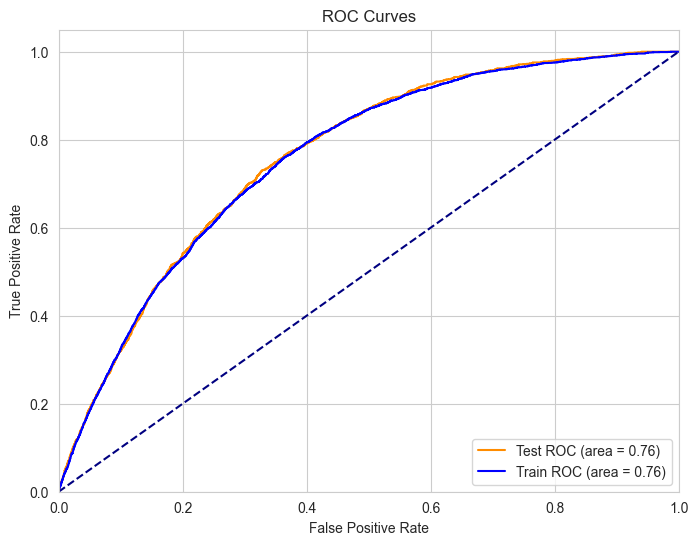

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# 1. ROC Curves for Train and Test
fpr_test, tpr_test, _ = roc_curve(test['Goal'], test['prob'])
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, _ = roc_curve(test2['Goal'], test2['prob'])
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='Test ROC (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue',
         label='Train ROC (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()


Confusion Matrix (Test):
 [[18685  4562]
 [  772   865]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.80      0.88     23247
           1       0.16      0.53      0.24      1637

    accuracy                           0.79     24884
   macro avg       0.56      0.67      0.56     24884
weighted avg       0.91      0.79      0.83     24884


Confusion Matrix (Train):
 [[43378 10787]
 [ 1830  2065]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     54165
           1       0.16      0.53      0.25      3895

    accuracy                           0.78     58060
   macro avg       0.56      0.67      0.56     58060
weighted avg       0.91      0.78      0.83     58060



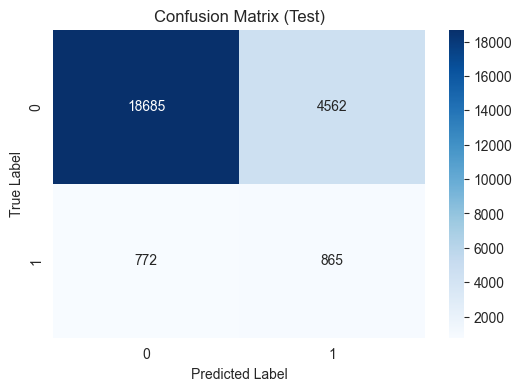

In [58]:
# 2. Confusion Matrix & Classification Report
# Choose a predicted probability 
threshold = 0.1

# Test set
y_pred_test = (test['prob'] >= threshold).astype(int)
cm_test = confusion_matrix(test['Goal'], y_pred_test)
print("Confusion Matrix (Test):\n", cm_test)
print("\nClassification Report (Test):")
print(classification_report(test['Goal'], y_pred_test))

# Train set
y_pred_train = (test2['prob'] >= threshold).astype(int)
cm_train = confusion_matrix(test2['Goal'], y_pred_train)
print("\nConfusion Matrix (Train):\n", cm_train)
print("\nClassification Report (Train):")
print(classification_report(test2['Goal'], y_pred_train))

# plot a heatmap for the test confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

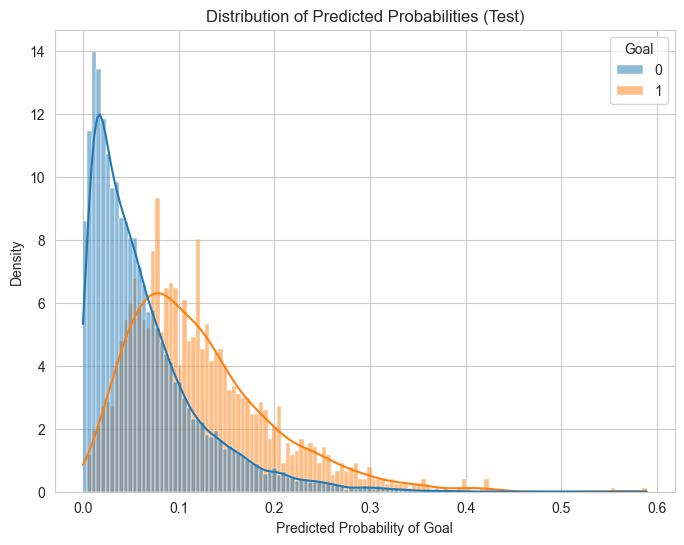

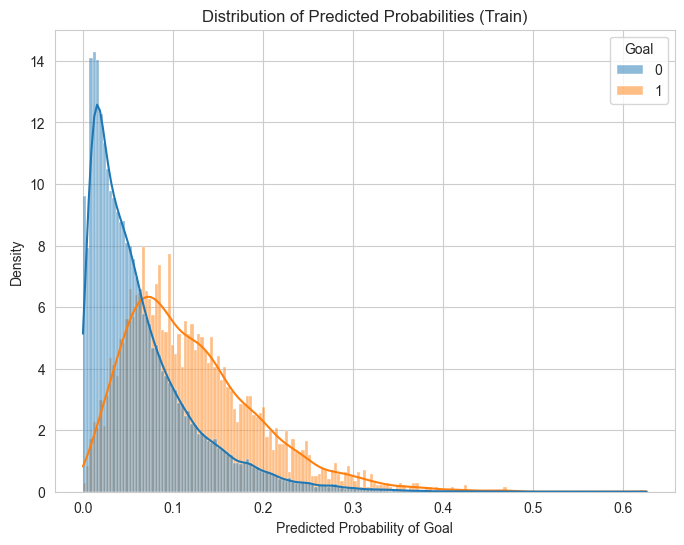

In [59]:
# 3. Distribution of Predicted Probabilities
# Compare distributions for "Goal=1" vs. "Goal=0" in test set
plt.figure(figsize=(8, 6))
sns.histplot(data=test, x='prob', hue='Goal', kde=True, stat='density', common_norm=False)
plt.title('Distribution of Predicted Probabilities (Test)')
plt.xlabel('Predicted Probability of Goal')
plt.ylabel('Density')
plt.show()

# training set if desired:
plt.figure(figsize=(8, 6))
sns.histplot(data=test2, x='prob', hue='Goal', kde=True, stat='density', common_norm=False)
plt.title('Distribution of Predicted Probabilities (Train)')
plt.xlabel('Predicted Probability of Goal')
plt.ylabel('Density')
plt.show()

In [60]:
print(df_xg_model.columns)


Index(['EventID', 'EventTeam', 'ShotDistance', 'ShotAngle', 'X', 'Y',
       'StrengthState', 'ScoreState', 'LastEvent', 'shotType', 'Player1',
       'Event', 'TSLE', 'is_rebound', 'Goal', 'playerId', 'Position',
       'is_forward'],
      dtype='object')


In [61]:
print(coef.keys())


Index(['features', 'coef'], dtype='object')


In [62]:
# Block 4:
# Compute actual probability for each event 

# xG = 1 / (1 + e^(-z)) 

# z = (WeightedShotDistance + WeightedShotAngle + WeightedStrengthState + 
#      WeightedScoreState + WeightedLastEvent + WeightedShotType + WeightedIsForward)

import pandas as pd
import numpy as np

xg_model_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/xgmodel.csv'
xg_coef_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/xgcoef.csv'

df_xg_model = pd.read_csv(xg_model_fp)    
df_xg_coef  = pd.read_csv(xg_coef_fp)    # Expected columns: ['features', 'coef']

# Convert the "features" & "coef" columns into a dictionary
coef_dict = df_xg_coef.set_index('features')['coef'].to_dict()

# 2. Create a Working Copy and Compute Weighted Values
df_xG_temp1 = df_xg_model.copy()

# (a) Weighted Continuous Features (do not overwrite the original ShotDistance & ShotAngle)
df_xG_temp1['WeightedShotDistance'] = df_xG_temp1['ShotDistance'] * coef_dict['ShotDistance']
df_xG_temp1['WeightedShotAngle']    = df_xG_temp1['ShotAngle']    * coef_dict['ShotAngle']

# (b) Map StrengthState to its coefficient; store result in WeightedStrengthState.
strength_conditions = [
    df_xG_temp1['StrengthState'] == 'EV1',
    df_xG_temp1['StrengthState'] == 'EV2',
    df_xG_temp1['StrengthState'] == 'PP1',
    df_xG_temp1['StrengthState'] == 'PP2',
    df_xG_temp1['StrengthState'] == 'SH'
]
strength_choices = [
    coef_dict['StrengthState_EV1'],
    coef_dict['StrengthState_EV2'],
    coef_dict['StrengthState_PP1'],
    coef_dict['StrengthState_PP2'],
    coef_dict['StrengthState_SH']
]
df_xG_temp1['WeightedStrengthState'] = np.select(strength_conditions, strength_choices, default=0)

# (c) Map ScoreState to its coefficient; store in WeightedScoreState.
score_conditions = [
    df_xG_temp1['ScoreState'] == '-1',
    df_xG_temp1['ScoreState'] == '-2',
    df_xG_temp1['ScoreState'] == '0',
    df_xG_temp1['ScoreState'] == '1',
    df_xG_temp1['ScoreState'] == '2',
    df_xG_temp1['ScoreState'] == '<-2',
    df_xG_temp1['ScoreState'] == '>2'
]
score_choices = [
    coef_dict['ScoreState_-1'],
    coef_dict['ScoreState_-2'],
    coef_dict['ScoreState_0'],
    coef_dict['ScoreState_1'],
    coef_dict['ScoreState_2'],
    coef_dict['ScoreState_<-2'],
    coef_dict['ScoreState_>2']
]
df_xG_temp1['WeightedScoreState'] = np.select(score_conditions, score_choices, default=0)

# (d) Map LastEvent to its coefficient; store in WeightedLastEvent.
le_conditions = [
    df_xG_temp1['LastEvent'] == 'No',
    df_xG_temp1['LastEvent'] == 'Shot',
    df_xG_temp1['LastEvent'] == 'Other'
]
le_choices = [
    coef_dict['LastEvent_No'],
    coef_dict['LastEvent_Shot'],
    coef_dict['LastEvent_Other']
]
df_xG_temp1['WeightedLastEvent'] = np.select(le_conditions, le_choices, default=0)

# (e) Map shotType to its coefficient; store in WeightedShotType.
st_conditions = [
    df_xG_temp1['shotType'] == 'bat',
    df_xG_temp1['shotType'] == 'between-legs',
    df_xG_temp1['shotType'] == 'cradle',
    df_xG_temp1['shotType'] == 'poke',
    df_xG_temp1['shotType'] == 'slap',
    df_xG_temp1['shotType'] == 'backhand',
    df_xG_temp1['shotType'] == 'deflected',
    df_xG_temp1['shotType'] == 'snap',
    df_xG_temp1['shotType'] == 'tip-in',
    df_xG_temp1['shotType'] == 'wrap-around',
    df_xG_temp1['shotType'] == 'wrist'
]
st_choices = [
    coef_dict['shotType_bat'],
    coef_dict['shotType_between-legs'],
    coef_dict['shotType_cradle'],
    coef_dict['shotType_poke'],
    coef_dict['shotType_slap'],
    coef_dict['shotType_backhand'],
    coef_dict['shotType_deflected'],
    coef_dict['shotType_snap'],
    coef_dict['shotType_tip-in'],
    coef_dict['shotType_wrap-around'],
    coef_dict['shotType_wrist']
]
df_xG_temp1['WeightedShotType'] = np.select(st_conditions, st_choices, default=0)

# (f) is_forward 
df_xG_temp1['WeightedIsForward'] = df_xG_temp1['is_forward'] * coef_dict['is_forward'] 

# (g) is_rebound 
df_xG_temp1['WeightedIsRebound'] = df_xG_temp1['is_rebound'] * coef_dict['is_rebound']


# 3. Compute xG Using the Logistic Function
# z = (WeightedShotDistance + WeightedShotAngle + WeightedStrengthState + 
#      WeightedScoreState + WeightedLastEvent + WeightedShotType + WeightedIsForward)

# xG = 1 / (1 + e^(-z))

sum_vars = (df_xG_temp1['WeightedShotDistance'] + 
            df_xG_temp1['WeightedShotAngle'] +
            df_xG_temp1['WeightedStrengthState'] +
            df_xG_temp1['WeightedScoreState'] +
            df_xG_temp1['WeightedLastEvent'] +
            df_xG_temp1['WeightedShotType'] +
            df_xG_temp1['WeightedIsForward']+
            df_xG_temp1['WeightedIsRebound']
           )

df_xG_temp1['xG'] = 1 / (1 + np.exp(-sum_vars))

# 4. Export the Result
print(df_xG_temp1[['EventID', 'EventTeam', 'Player1', 'ShotDistance', 'ShotAngle', 
                     'StrengthState', 'ScoreState', 'LastEvent', 'shotType', 'is_forward', 'xG']].head())

# Export the full DataFrame to CSV
output_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv'
df_xG_temp1.to_csv(output_fp, index=False)
print("Export complete: xg_results.csv has been saved.")


          EventID EventTeam  Player1  ShotDistance  ShotAngle StrengthState  \
0  20240200010001       NJD  8483495     51.224994  51.340192           EV1   
1  20240200010002       NJD  8479407     33.286634  57.264774           EV1   
2  20240200010003       NJD  8476462     47.507894  30.343249           EV1   
3  20240200010004       BUF  8482175     57.140179  32.855722           EV1   
4  20240200010005       BUF  8482671     55.081757  15.802514           EV1   

  ScoreState LastEvent shotType  is_forward        xG  
0          0     Other    wrist           0  0.010259  
1          0        No    wrist           1  0.035103  
2          0        No     slap           0  0.032869  
3          0        No    wrist           1  0.012412  
4          0     Other     slap           0  0.019640  
Export complete: xg_results.csv has been saved.


In [63]:
print("\nSummary Statistics for xG Probability:")
print(df_xG_temp1['xG'].describe()) 

df_xG_temp1 = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')
print(df_xG_temp1.columns)  


Summary Statistics for xG Probability:
count    82944.000000
mean         0.067121
std          0.061545
min          0.000004
25%          0.022119
50%          0.049534
75%          0.092011
max          0.625637
Name: xG, dtype: float64
Index(['EventID', 'EventTeam', 'ShotDistance', 'ShotAngle', 'X', 'Y',
       'StrengthState', 'ScoreState', 'LastEvent', 'shotType', 'Player1',
       'Event', 'TSLE', 'is_rebound', 'Goal', 'playerId', 'Position',
       'is_forward', 'WeightedShotDistance', 'WeightedShotAngle',
       'WeightedStrengthState', 'WeightedScoreState', 'WeightedLastEvent',
       'WeightedShotType', 'WeightedIsForward', 'WeightedIsRebound', 'xG'],
      dtype='object')


In [67]:
# Block 5:
# Compute xG for each game 

import pandas as pd
import numpy as np

# Step 1: Load Event-Level xG Predictions and Extract GameID
df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')
# Extract GameID from EventID (assuming EventID = GameID*10000 + row_number)
df_xg['GameID'] = df_xg['EventID'] // 10000

# Step 2: Load Play-by-Play Data to Get the Shooting Team
# pbp_adjusted.csv has columns including EventID and EventTeam.
df_pbp = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/pbp_adjusted.csv')
df_events = pd.merge(df_xg, df_pbp[['EventID', 'EventTeam']], on='EventID', how='left')

# Step 3: Aggregate xG by Game and Team
# Group by GameID and EventTeam to get total expected goals (Team_xG) for each team.
df_team_xg = (df_xg
    .groupby(['GameID', 'EventTeam'], as_index=False)['xG']
    .sum()
    .rename(columns={'xG': 'Team_xG'})
)

# Step 4: Load and Prepare Schedule Data
df_schedule = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/schedule.csv')

# Rename schedule columns to avoid conflicts
df_schedule.rename(columns={
    'Team': 'SchedTeam',
    'Opponent': 'SchedOpponent',
    'Venue': 'SchedVenue'
}, inplace=True)

# Derive HomeTeam and AwayTeam based on scheduled venue:
df_schedule['HomeTeam'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                   df_schedule['SchedTeam'],
                                   df_schedule['SchedOpponent'])
df_schedule['AwayTeam'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                   df_schedule['SchedOpponent'],
                                   df_schedule['SchedTeam'])

# Derive actual scores (if applicable)
df_schedule['HomeScore'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                    df_schedule['GF'],
                                    df_schedule['GA'])
df_schedule['AwayScore'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                    df_schedule['GA'],
                                    df_schedule['GF'])

# Convert GameDate to datetime.date for proper sorting
df_schedule['gameDate'] = pd.to_datetime(df_schedule['GameDate']).dt.date

# Drop duplicate rows by GameID if any exist
df_schedule.drop_duplicates(subset=['GameID'], inplace=True)

# Step 5: Merge Aggregated xG with Schedule Data for Home and Away Teams Separately
# Merge home team xG: match schedule HomeTeam with EventTeam in df_team_xg.
df_home = pd.merge(df_schedule[['GameID', 'HomeTeam']], df_team_xg,
                   left_on=['GameID', 'HomeTeam'],
                   right_on=['GameID', 'EventTeam'],
                   how='left')
df_home.rename(columns={'Team_xG': 'Home_xG'}, inplace=True)
df_home = df_home[['GameID', 'Home_xG']]

# Merge away team xG: match schedule AwayTeam with EventTeam.
df_away = pd.merge(df_schedule[['GameID', 'AwayTeam']], df_team_xg,
                   left_on=['GameID', 'AwayTeam'],
                   right_on=['GameID', 'EventTeam'],
                   how='left')
df_away.rename(columns={'Team_xG': 'Away_xG'}, inplace=True)
df_away = df_away[['GameID', 'Away_xG']]

# Merge the home and away xG values into schedule
df_final = pd.merge(df_schedule, df_home, on='GameID', how='left')
df_final = pd.merge(df_final, df_away, on='GameID', how='left')

# Replace missing xG with 0 (if no xG events were recorded for that team in a game)
df_final['Home_xG'] = df_final['Home_xG'].fillna(0)
df_final['Away_xG'] = df_final['Away_xG'].fillna(0)

# Step 6: Sort Final Data by gameDate (Earliest Game First) and Print Summary Stats
df_final.sort_values(by='gameDate', inplace=True)

print("Summary of Total xG for Home Teams:")
print(df_final['Home_xG'].describe())

print("\nSummary of Total xG for Away Teams:")
print(df_final['Away_xG'].describe())

print("\nFirst few rows of final game-level data:")
print(df_final[['gameDate', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Home_xG', 'Away_xG']].head())

# Step 7: Export Final Data to CSV
output_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/game_team_xg.csv'
df_final[['GameID', 'gameDate', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Home_xG', 'Away_xG']].to_csv(output_fp, index=False)
print("Export complete: game_team_xg.csv has been saved.")


Summary of Total xG for Home Teams:
count    965.000000
mean       2.989999
std        0.925661
min        1.025771
25%        2.361491
50%        2.873224
75%        3.497349
max       10.693545
Name: Home_xG, dtype: float64

Summary of Total xG for Away Teams:
count    965.000000
mean       2.779205
std        0.877820
min        0.839498
25%        2.179003
50%        2.687663
75%        3.214467
max       11.513753
Name: Away_xG, dtype: float64

First few rows of final game-level data:
       gameDate HomeTeam AwayTeam  HomeScore  AwayScore   Home_xG   Away_xG
430  2024-10-04      BUF      NJD          1          4  2.746355  2.299156
362  2024-10-05      NJD      BUF          3          1  3.675452  1.873902
0    2024-10-08      SEA      STL          2          3  3.359978  2.213375
199  2024-10-08      UTA      CHI          5          2  2.616813  3.127349
871  2024-10-08      FLA      BOS          6          4  4.562974  2.616052
Export complete: game_team_xg.csv has been saved.

In [68]:
# Block 6: 
# Team Level Analysis 
# Calculate a team's GF%, xGF%, dGF% 

# 1. Load the Final Game-Level xG Data
fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/game_team_xg.csv'
df_final = pd.read_csv(fp)

# Ensure gameDate is in datetime format for proper sorting if needed
df_final['gameDate'] = pd.to_datetime(df_final['gameDate']).dt.date

# 2. Create Home and Away DataFrames with Consistent Column Names
# For home games:
home_df = df_final[['GameID', 'gameDate', 'HomeTeam', 'HomeScore', 'AwayScore', 'Home_xG', 'Away_xG']].copy()
home_df.rename(columns={
    'HomeTeam': 'Team',
    'HomeScore': 'GF',    # Goals For
    'AwayScore': 'GA',    # Goals Against
    'Home_xG': 'xGF',     # Expected Goals For
    'Away_xG': 'xGA'      # Expected Goals Against
}, inplace=True)

# For away games:
away_df = df_final[['GameID', 'gameDate', 'AwayTeam', 'AwayScore', 'HomeScore', 'Away_xG', 'Home_xG']].copy()
away_df.rename(columns={
    'AwayTeam': 'Team',
    'AwayScore': 'GF',    # Goals For
    'HomeScore': 'GA',    # Goals Against
    'Away_xG': 'xGF',     # Expected Goals For
    'Home_xG': 'xGA'      # Expected Goals Against
}, inplace=True)

# 3. Combine Home and Away Data
df_teams_games = pd.concat([home_df, away_df], axis=0, ignore_index=True)

# 4. Group by Team to Compute Season Totals
team_stats = df_teams_games.groupby('Team').agg({
    'GF': 'sum',
    'GA': 'sum',
    'xGF': 'sum',
    'xGA': 'sum'
}).reset_index()

# Compute GF%: 
# Goals For / (Goals For + Goals Against)
team_stats['GF%'] = np.where(team_stats['GF'] + team_stats['GA'] > 0,
                             team_stats['GF'] / (team_stats['GF'] + team_stats['GA']) * 100,
                             0)

# Compute xGF%: 
# Expected Goals For / (xGF + xGA)
team_stats['xGF%'] = np.where(team_stats['xGF'] + team_stats['xGA'] > 0,
                              team_stats['xGF'] / (team_stats['xGF'] + team_stats['xGA']) * 100,
                              0)

# Compute dGF%: 
# difference between actual and expected goal percentages
team_stats['dGF%'] = team_stats['GF%'] - team_stats['xGF%']

# 5. Print Summary Statistics for Each Team
print("Season Stats for Each Team:")
print(team_stats)

print("\nSummary Statistics for GF%:")
print(team_stats['GF%'].describe())

print("\nSummary Statistics for xGF%:")
print(team_stats['xGF%'].describe())

print("\nSummary Statistics for dGF%:")
print(team_stats['dGF%'].describe())

# 6. Export the Season Stats to CSV
output_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model/season_team_stats.csv'
team_stats.to_csv(output_fp, index=False)
print("Export complete: season_team_stats.csv has been saved.")


Season Stats for Each Team:
   Team   GF   GA         xGF         xGA        GF%       xGF%      dGF%
0   ANA  154  183  156.061704  209.332883  45.697329  42.710459  2.986871
1   BOS  167  195  174.133560  174.526500  46.132597  49.943650 -3.811053
2   BUF  186  198  161.237419  169.609108  48.437500  48.734808 -0.297308
3   CAR  195  170  205.688176  160.233058  53.424658  56.211052 -2.786395
4   CBJ  205  196  164.581061  183.589244  51.122195  47.270275  3.851919
5   CGY  155  176  160.102546  177.181529  46.827795  47.468160 -0.640366
6   CHI  164  213  150.020268  191.453581  43.501326  43.933165 -0.431838
7   COL  198  182  184.031091  162.578062  52.105263  53.094700 -0.989437
8   DAL  206  155  202.014746  178.072340  57.063712  53.149595  3.914117
9   DET  176  191  168.849154  172.999041  47.956403  49.393022 -1.436619
10  EDM  195  174  197.735476  161.258832  52.845528  55.080393 -2.234865
11  FLA  204  171  190.899645  156.463347  54.400000  54.956817 -0.556817
12  LAK  1

Top 9 Teams by dGF%:
   Team        GF%       xGF%      dGF%
30  WPG  59.943978  51.977158  7.966820
31  WSH  57.795699  50.574745  7.220954
25  TBL  57.493188  53.256039  4.237149
8   DAL  57.063712  53.149595  3.914117
4   CBJ  51.122195  47.270275  3.851919
0   ANA  45.697329  42.710459  2.986871
18  NYR  50.000000  47.272238  2.727762
26  TOR  53.005464  50.290661  2.714804
13  MIN  49.570201  47.943427  1.626774

Bottom 9 Teams by dGF%:
   Team        GF%       xGF%      dGF%
17  NYI  48.387097  49.718577 -1.331480
9   DET  47.956403  49.393022 -1.436619
10  EDM  52.845528  55.080393 -2.234865
3   CAR  53.424658  56.211052 -2.786395
23  SJS  40.568475  43.746371 -3.177895
1   BOS  46.132597  49.943650 -3.811053
20  PHI  47.120419  52.156464 -5.036045
21  PIT  43.990385  50.351075 -6.360690
16  NSH  43.220339  50.295400 -7.075061

League Totals: 32 teams
Sum of GF: 5826, Sum of xGF: 5567.280987220336
Average GF%: 50.0%, Average xGF%: 50.0%


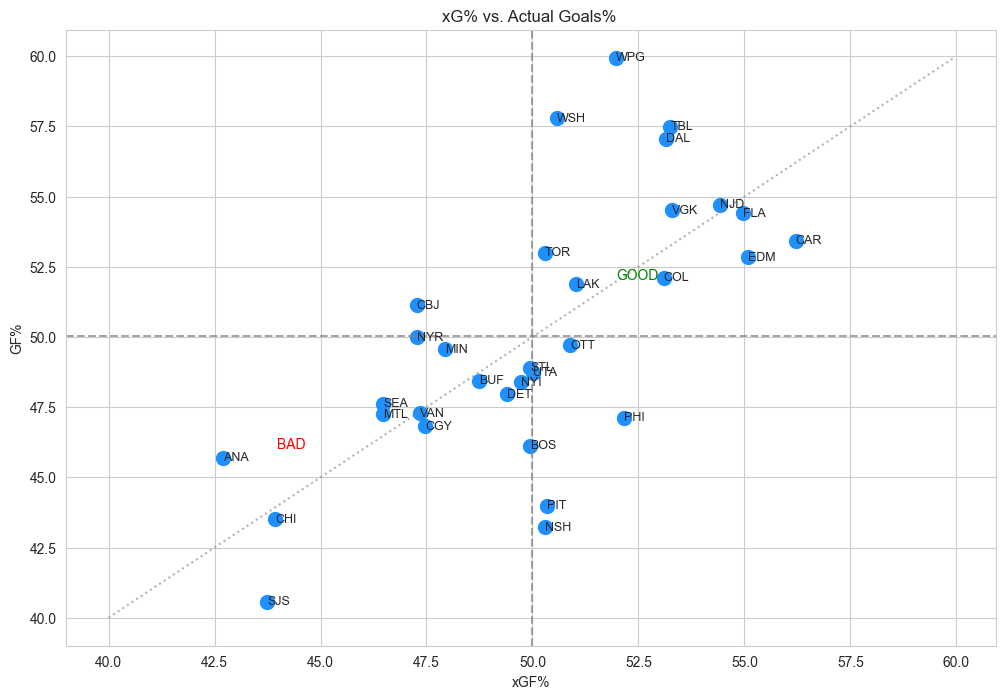

In [69]:
# 2. Graph xG% vs. GF% 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

team_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/season_team_stats.csv')

# 2. Compute League Averages for GF% and xGF%
avg_GF_percent = team_stats['GF%'].mean()
avg_xGF_percent = team_stats['xGF%'].mean()

# 3. Create a Scatter Plot: x-axis = xGF%, y-axis = GF%
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Scatter: each point is a team
plt.scatter(team_stats['xGF%'], team_stats['GF%'], s=100, color='dodgerblue')

# Add vertical and horizontal lines for the league averages
plt.axvline(x=avg_xGF_percent, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=avg_GF_percent, color='gray', linestyle='--', alpha=0.7)

# Label each point with the team abbreviation
for i, row in team_stats.iterrows():
    plt.text(
        row['xGF%'] ,   # small horizontal offset
        row['GF%'], 
        row['Team'],
        fontsize=9,
        ha='left', 
        va='center'
    )

# (y = x):
max_val = max(team_stats['GF%'].max(), team_stats['xGF%'].max())
plt.plot([40, max_val], [40, max_val], color='gray', linestyle=':', alpha=0.6)

# Optionally label quadrants (example):
plt.text(avg_xGF_percent + 2, avg_GF_percent + 2, 'GOOD', fontsize=10, color='green')
plt.text(avg_xGF_percent - 6, avg_GF_percent - 4, 'BAD', fontsize=10, color='red')

plt.xlabel('xGF%')
plt.ylabel('GF%')
plt.title('xG% vs. Actual Goals% ')

# 4. Identify Top 9 / Bottom 9 Teams by dGF% (GF% - xGF%)
df_sorted = team_stats.sort_values('dGF%', ascending=False)
top_9 = df_sorted.head(9)
bottom_9 = df_sorted.tail(9)

print("Top 9 Teams by dGF%:")
print(top_9[['Team', 'GF%', 'xGF%', 'dGF%']])

print("\nBottom 9 Teams by dGF%:")
print(bottom_9[['Team', 'GF%', 'xGF%', 'dGF%']])

# 5. Summaries of League Stats
# Example: total goals, average xGF, average GF, etc.
total_goals_for = team_stats['GF'].sum()
total_xg_for = team_stats['xGF'].sum()
avg_gf_percent = team_stats['GF%'].mean()
avg_xgf_percent = team_stats['xGF%'].mean()

print(f"\nLeague Totals: {len(team_stats)} teams")
print(f"Sum of GF: {total_goals_for}, Sum of xGF: {total_xg_for}")
print(f"Average GF%: {avg_gf_percent:.1f}%, Average xGF%: {avg_xgf_percent:.1f}%")

# 6. Show the Plot
plt.show()


In [70]:
# 4. Identify Top 9 / Bottom 9 Teams by xGF% 
df_sorted = team_stats.sort_values('xGF%', ascending=False)
top_9 = df_sorted.head(9)
bottom_9 = df_sorted.tail(9)

print("Top 9 Teams by xGF%:")
print(top_9[['Team', 'GF%', 'xGF%', 'dGF%']])

print("\nBottom 9 Teams by xGF%:")
print(bottom_9[['Team', 'GF%', 'xGF%', 'dGF%']])

Top 9 Teams by xGF%:
   Team        GF%       xGF%      dGF%
3   CAR  53.424658  56.211052 -2.786395
10  EDM  52.845528  55.080393 -2.234865
11  FLA  54.400000  54.956817 -0.556817
15  NJD  54.705882  54.422354  0.283528
29  VGK  54.520548  53.288209  1.232339
25  TBL  57.493188  53.256039  4.237149
8   DAL  57.063712  53.149595  3.914117
7   COL  52.105263  53.094700 -0.989437
20  PHI  47.120419  52.156464 -5.036045

Bottom 9 Teams by xGF%:
   Team        GF%       xGF%      dGF%
5   CGY  46.827795  47.468160 -0.640366
28  VAN  47.277937  47.340924 -0.062987
18  NYR  50.000000  47.272238  2.727762
4   CBJ  51.122195  47.270275  3.851919
14  MTL  47.244094  46.476601  0.767494
22  SEA  47.619048  46.474966  1.144081
6   CHI  43.501326  43.933165 -0.431838
23  SJS  40.568475  43.746371 -3.177895
0   ANA  45.697329  42.710459  2.986871


In [71]:
# 3. Calculate team's xGF, xGA per Game 

df_schedule = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/schedule.csv')

# 2. Reshape so each row is (GameID, Team)
df_home = df_schedule[['GameID', 'Team']].rename(columns={'HomeTeam':'Team'})
df_away = df_schedule[['GameID', 'Opponent']].rename(columns={'AwayTeam':'Team'})
df_teams = pd.concat([df_home, df_away], ignore_index=True)

# 3. Count how many times each Team appears => Games Played
df_games_played = df_teams.groupby('Team')['GameID'].nunique().reset_index()
df_games_played.rename(columns={'GameID':'GamesPlayed'}, inplace=True)

# 4. Load your season_team_stats.csv with columns: Team, xGF, xGA, etc.
df_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/season_team_stats.csv')

# 5. Merge in the number of games played
df_stats = pd.merge(df_stats, df_games_played, on='Team', how='left')

# 6. Now compute xGF_per60 and xGA_per60
df_stats['xGF_perGame'] = (df_stats['xGF'] / df_stats['GamesPlayed'])
df_stats['xGA_perGame'] = (df_stats['xGA'] / df_stats['GamesPlayed']) 

# 7. Print and export
print(df_stats[['Team', 'GamesPlayed', 'xGF', 'xGA', 'xGF_perGame', 'xGA_perGame']].head(32))

df_stats.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/season_team_stats_with_rates.csv', index=False)
print("Export complete: season_team_stats_with_rates.csv has been saved.")


   Team  GamesPlayed         xGF         xGA  xGF_perGame  xGA_perGame
0   ANA           59  156.061704  209.332883     2.645114     3.548015
1   BOS           62  174.133560  174.526500     2.808606     2.814944
2   BUF           58  161.237419  169.609108     2.779956     2.924295
3   CAR           61  205.688176  160.233058     3.371937     2.626771
4   CBJ           60  164.581061  183.589244     2.743018     3.059821
5   CGY           60  160.102546  177.181529     2.668376     2.953025
6   CHI           60  150.020268  191.453581     2.500338     3.190893
7   COL           61  184.031091  162.578062     3.016903     2.665214
8   DAL           60  202.014746  178.072340     3.366912     2.967872
9   DET           60  168.849154  172.999041     2.814153     2.883317
10  EDM           60  197.735476  161.258832     3.295591     2.687647
11  FLA           61  190.899645  156.463347     3.129502     2.564973
12  LAK           58  156.466236  150.193750     2.697694     2.589547
13  MI

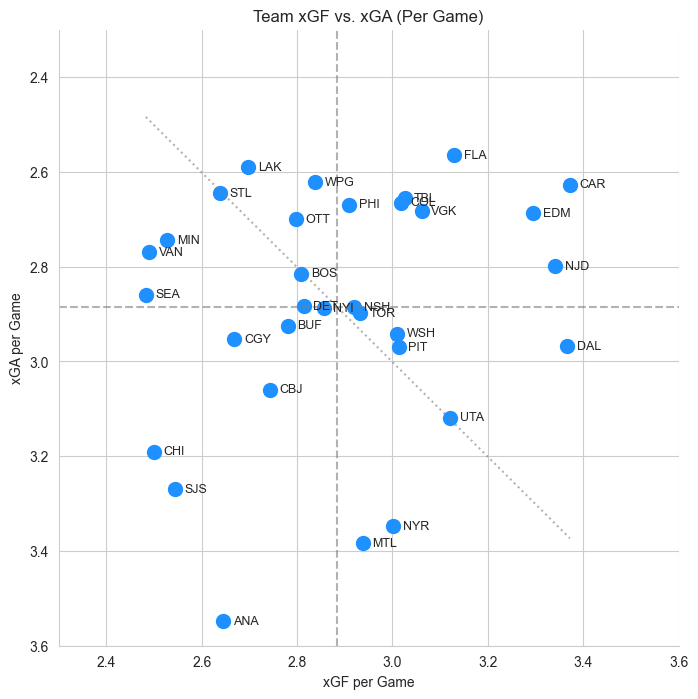

In [72]:
# 4. xGF per Game vs. xGA per game analysis 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Your Updated Season Stats with xGF_perGame and xGA_perGame
df_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/season_team_stats_with_rates.csv')
# Columns expected to include: Team, xGF_perGame, xGA_perGame, GamesPlayed, etc.

# 2. Compute League Averages for xGF_perGame and xGA_perGame
mean_xGF = df_stats['xGF_perGame'].mean()
mean_xGA = df_stats['xGA_perGame'].mean()

# 3. Create the Scatter Plot
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")

# Plot each team as a point
plt.scatter(df_stats['xGF_perGame'], df_stats['xGA_perGame'], s=100, color='dodgerblue')

# Draw vertical/horizontal lines at league averages
plt.axvline(x=mean_xGF, color='gray', linestyle='--', alpha=0.6)
plt.axhline(y=mean_xGA, color='gray', linestyle='--', alpha=0.6)

x_vals = np.linspace(df_stats['xGF_perGame'].min(), df_stats['xGF_perGame'].max(), 100)
y_vals = (x_vals - mean_xGF) + mean_xGA
plt.plot(x_vals, y_vals, color='gray', linestyle=':', alpha=0.6)

# Label each point with the team abbreviation
for i, row in df_stats.iterrows():
    plt.text(
        row['xGF_perGame'] + 0.02,  # small horizontal offset
        row['xGA_perGame'],
        row['Team'],
        fontsize=9,
        ha='left',
        va='center'
    )

# 4. Final Touches
plt.xlabel('xGF per Game')
plt.ylabel('xGA per Game')
plt.title("Team xGF vs. xGA (Per Game)")

plt.xlim(2.3, 3.6)
plt.ylim(2.3,3.6)

plt.gca().invert_yaxis() #invery y-axis 
sns.despine()  # remove top/right spines for a cleaner look

plt.show()


In [73]:
# 5. Team's Actual GF, GA 

import pandas as pd
import numpy as np

# 1. Load schedule with columns: GameID, HomeTeam, AwayTeam, ...
df_schedule = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/schedule.csv')

# 2. Reshape so each row is (GameID, Team)
df_home = df_schedule[['GameID', 'Team']].rename(columns={'HomeTeam':'Team'})
df_away = df_schedule[['GameID', 'Opponent']].rename(columns={'AwayTeam':'Team'})
df_teams = pd.concat([df_home, df_away], ignore_index=True)

# 3. Count how many times each Team appears => Games Played
df_games_played = df_teams.groupby('Team')['GameID'].nunique().reset_index()
df_games_played.rename(columns={'GameID':'GamesPlayed'}, inplace=True)

# 4. Load your season_team_stats.csv with columns: Team, xGF, xGA, etc.
df_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/season_team_stats.csv')

# 5. Merge in the number of games played
df_stats = pd.merge(df_stats, df_games_played, on='Team', how='left')

# 6. Now compute xGF_per60 and xGA_per60
df_stats['GF_perGame'] = (df_stats['GF'] / df_stats['GamesPlayed'])
df_stats['GA_perGame'] = (df_stats['GA'] / df_stats['GamesPlayed']) 

# 7. Print and export
print(df_stats[['Team', 'GamesPlayed', 'GF', 'GA', 'GF_perGame', 'GA_perGame']].head())

df_stats.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/season_team_gfga.csv', index=False)

  Team  GamesPlayed   GF   GA  GF_perGame  GA_perGame
0  ANA           59  154  183    2.610169    3.101695
1  BOS           62  167  195    2.693548    3.145161
2  BUF           58  186  198    3.206897    3.413793
3  CAR           61  195  170    3.196721    2.786885
4  CBJ           60  205  196    3.416667    3.266667


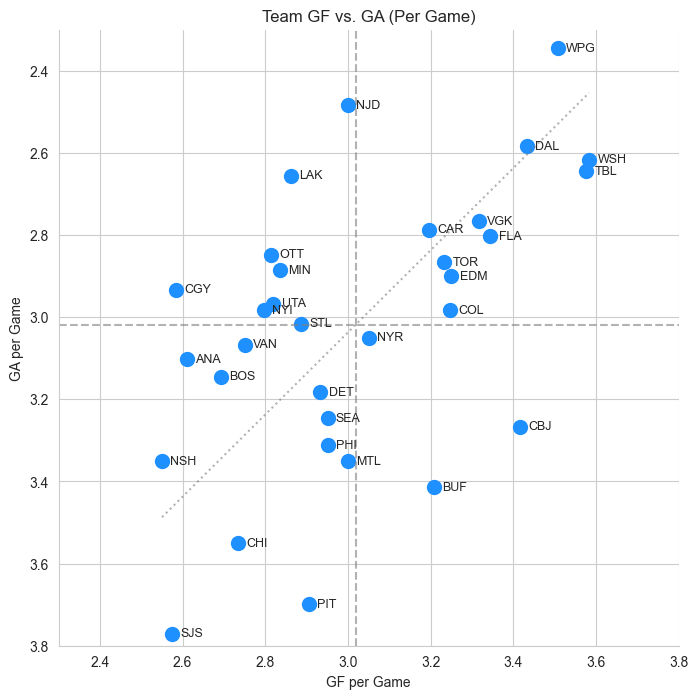

In [74]:
# GF VS. GA Graph 

df_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/season_team_gfga.csv')

# 2. Compute League Averages for xGF_perGame and xGA_perGame
mean_xGF = df_stats['GF_perGame'].mean()
mean_xGA = df_stats['GA_perGame'].mean()

# 3. Create the Scatter Plot
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")

# Plot each team as a point
plt.scatter(df_stats['GF_perGame'], df_stats['GA_perGame'], s=100, color='dodgerblue')

# Draw vertical/horizontal lines at league averages
plt.axvline(x=mean_xGF, color='gray', linestyle='--', alpha=0.6)
plt.axhline(y=mean_xGA, color='gray', linestyle='--', alpha=0.6)

x_vals = np.linspace(df_stats['GF_perGame'].min(), df_stats['GF_perGame'].max(), 100)
y_vals = -(x_vals - mean_xGF) + mean_xGA
plt.plot(x_vals, y_vals, color='gray', linestyle=':', alpha=0.6)

# Label each point with the team abbreviation
for i, row in df_stats.iterrows():
    plt.text(
        row['GF_perGame'] + 0.02,  # small horizontal offset
        row['GA_perGame'],
        row['Team'],
        fontsize=9,
        ha='left',
        va='center'
    )

# 4. Final Touches
plt.xlabel('GF per Game')
plt.ylabel('GA per Game')
plt.title("Team GF vs. GA (Per Game)")

plt.xlim(2.3, 3.8)
plt.ylim(2.3,3.8) 

plt.gca().invert_yaxis() #invery y-axis 
sns.despine()  # remove top/right spines for a cleaner look

plt.show() 

In [75]:
#Block 7: 
# Individual Player Analysis 
# 1. Calculate each player’s xG 


# 1. Read the xG results
df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')   

# 2. Compute total xG per player (Player1)
df_player_xg = (
    df_xg.groupby('Player1', as_index=False)
         .agg({'xG': 'sum', 'Goal': 'sum'})
         .rename(columns={'xG': 'Total_xG', 'Goal': 'Total_Goals'})
)

# 3. Read the player CSV
df_players = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')  

# 4. Merge the total xG with the player info
df_merged = pd.merge(
    df_player_xg, 
    df_players[['playerId','Player']],  # or more columns if needed
    left_on='Player1',
    right_on='playerId',
    how='left'
)

# 5. Sort descending by xG and select top 20
df_top20 = df_merged.sort_values("Total_xG", ascending=False).head(20)

# 6. Print the results
print("Top 20 players by total xG:")

print(df_top20[['Player1', 'Player', 'Total_xG', 'Total_Goals']])

Top 20 players by total xG:
     Player1            Player   Total_xG  Total_Goals
620  8481559       Jack Hughes  29.294117           33
105  8475786        Zach Hyman  27.421705           20
536  8480801     Brady Tkachuk  27.397624           22
760  8482740    Wyatt Johnston  26.217040           21
280  8477946      Dylan Larkin  25.553229           22
273  8477934    Leon Draisaitl  24.999997           42
158  8476483    Rickard Rakell  24.935718           30
243  8477492  Nathan MacKinnon  24.219395           20
178  8476881       Tomas Hertl  24.219306           19
272  8477933      Sam Reinhart  24.039281           31
613  8481540     Cole Caufield  23.838035           31
619  8481557        Matt Boldy  23.598726           21
79   8475314        Anders Lee  23.432577           22
11   8473419     Brad Marchand  22.873101           17
300  8478010     Brayden Point  22.816619           29
289  8477956    David Pastrnak  22.787782           29
326  8478398       Kyle Connor  22.70

In [76]:
df_topg20 = df_merged.sort_values("Total_Goals", ascending=False).head(20)

# 6. Print the results
print("Top 20 players by total Goals:")

print(df_topg20[['Player1', 'Player', 'Total_xG', 'Total_Goals']])

Top 20 players by total Goals:
     Player1            Player   Total_xG  Total_Goals
273  8477934    Leon Draisaitl  24.999997           42
620  8481559       Jack Hughes  29.294117           33
147  8476460    Mark Scheifele  20.119030           32
613  8481540     Cole Caufield  23.838035           31
272  8477933      Sam Reinhart  24.039281           31
276  8477939  William Nylander  20.636267           30
158  8476483    Rickard Rakell  24.935718           30
411  8479337    Alex DeBrincat  22.173778           29
289  8477956    David Pastrnak  22.787782           29
300  8478010     Brayden Point  22.816619           29
326  8478398       Kyle Connor  22.707754           29
440  8479420     Tage Thompson  16.772773           27
223  8477404     Jake Guentzel  22.308086           27
486  8480014   Gabriel Vilardi  18.572721           26
480  8480002     Nico Hischier  22.456277           25
490  8480027   Jason Robertson  19.725421           25
177  8476880        Tom Wilson  19

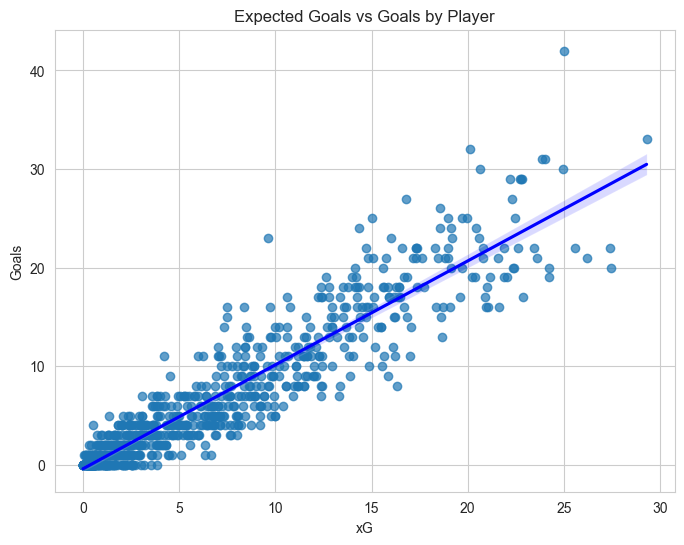

Model Evaluation Metrics:
  Pearson Correlation (Goals vs xG): 0.931
  R^2: 0.865
  RMSE: 2.625


In [77]:
# 2. Graph xG and G by Player

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')

# 2. Compute total xG and total goals per player
df_player_xg = (
    df_xg.groupby('Player1', as_index=False)
         .agg({'xG': 'sum', 'Goal': 'sum'})
         .rename(columns={'xG': 'Total_xG', 'Goal': 'Total_Goals'})
)

df_players = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')

# 4. Merge xG/goals with player info
#    (Match Player1 with playerId)
df_merged = pd.merge(
    df_player_xg,
    df_players[['playerId', 'Player']],  # pick any extra columns if needed
    left_on='Player1',
    right_on='playerId',
    how='left'
)

# 5. Create a scatter plot with regression line
#    using seaborn's regplot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.regplot(
    data=df_merged,
    x='Total_xG',
    y='Total_Goals',
    scatter_kws={'alpha': 0.7},  # transparency of the dots
    line_kws={'color': 'blue'}
)

plt.title("Expected Goals vs Goals by Player")
plt.xlabel("xG")
plt.ylabel("Goals")

plt.show()


# Model Evaluation based on Players' Goal vs. xG 

# Pearson correlation
pearson_corr = df_merged[['Total_xG','Total_Goals']].corr(method='pearson').iloc[0,1]

# R^2 (coefficient of determination)
r2 = r2_score(df_merged['Total_Goals'], df_merged['Total_xG'])

# RMSE (root mean squared error)
rmse = np.sqrt(mean_squared_error(df_merged['Total_Goals'], df_merged['Total_xG']))

print("Model Evaluation Metrics:")
print(f"  Pearson Correlation (Goals vs xG): {pearson_corr:.3f}")
print(f"  R^2: {r2:.3f}")
print(f"  RMSE: {rmse:.3f}")


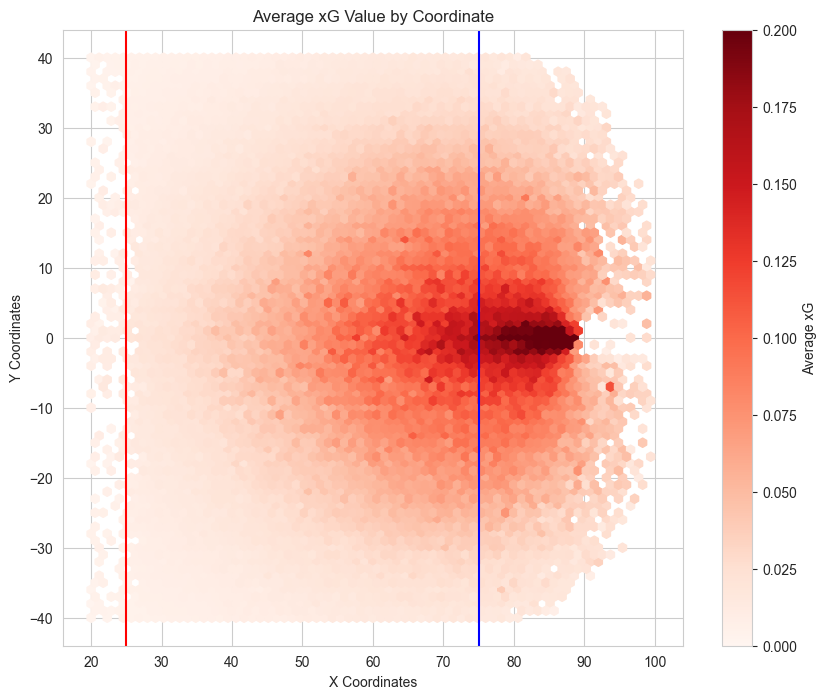

In [78]:
# 3. xG by on ice position graph 

df = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')

# 2. Filter to only include data where X >= 0
df = df[(df["X"] >= 0) & (df["Y"].abs() <= 40)]

# 3. Create the figure
plt.figure(figsize=(10, 8))

# 4. Plot a 2D hexbin, coloring by average xG in each bin
#    - reduce_C_function=np.mean calculates the mean xG per hex cell
#    - gridsize adjusts the resolution (try different values)
#    - extent sets the x/y axis boundaries
hb = plt.hexbin(
    df["X"], df["Y"], C=df["xG"],
    gridsize=70,
    reduce_C_function=np.mean,
    cmap="Reds",
    extent=(20, 100, -40, 40),  # X from 0 to 100, Y from -50 to 50
    vmin=0, vmax=0.2
)

# 5. Add colorbar
cb = plt.colorbar(hb, label="Average xG")

# 6. add vertical lines at x=25 or x=75 
plt.axvline(x=25, color="red", linewidth=1.5)
plt.axvline(x=75, color="blue", linewidth=1.5)

# 7. Label and title
plt.title("Average xG Value by Coordinate")
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")

plt.show()


Enter a playerId:  8476453


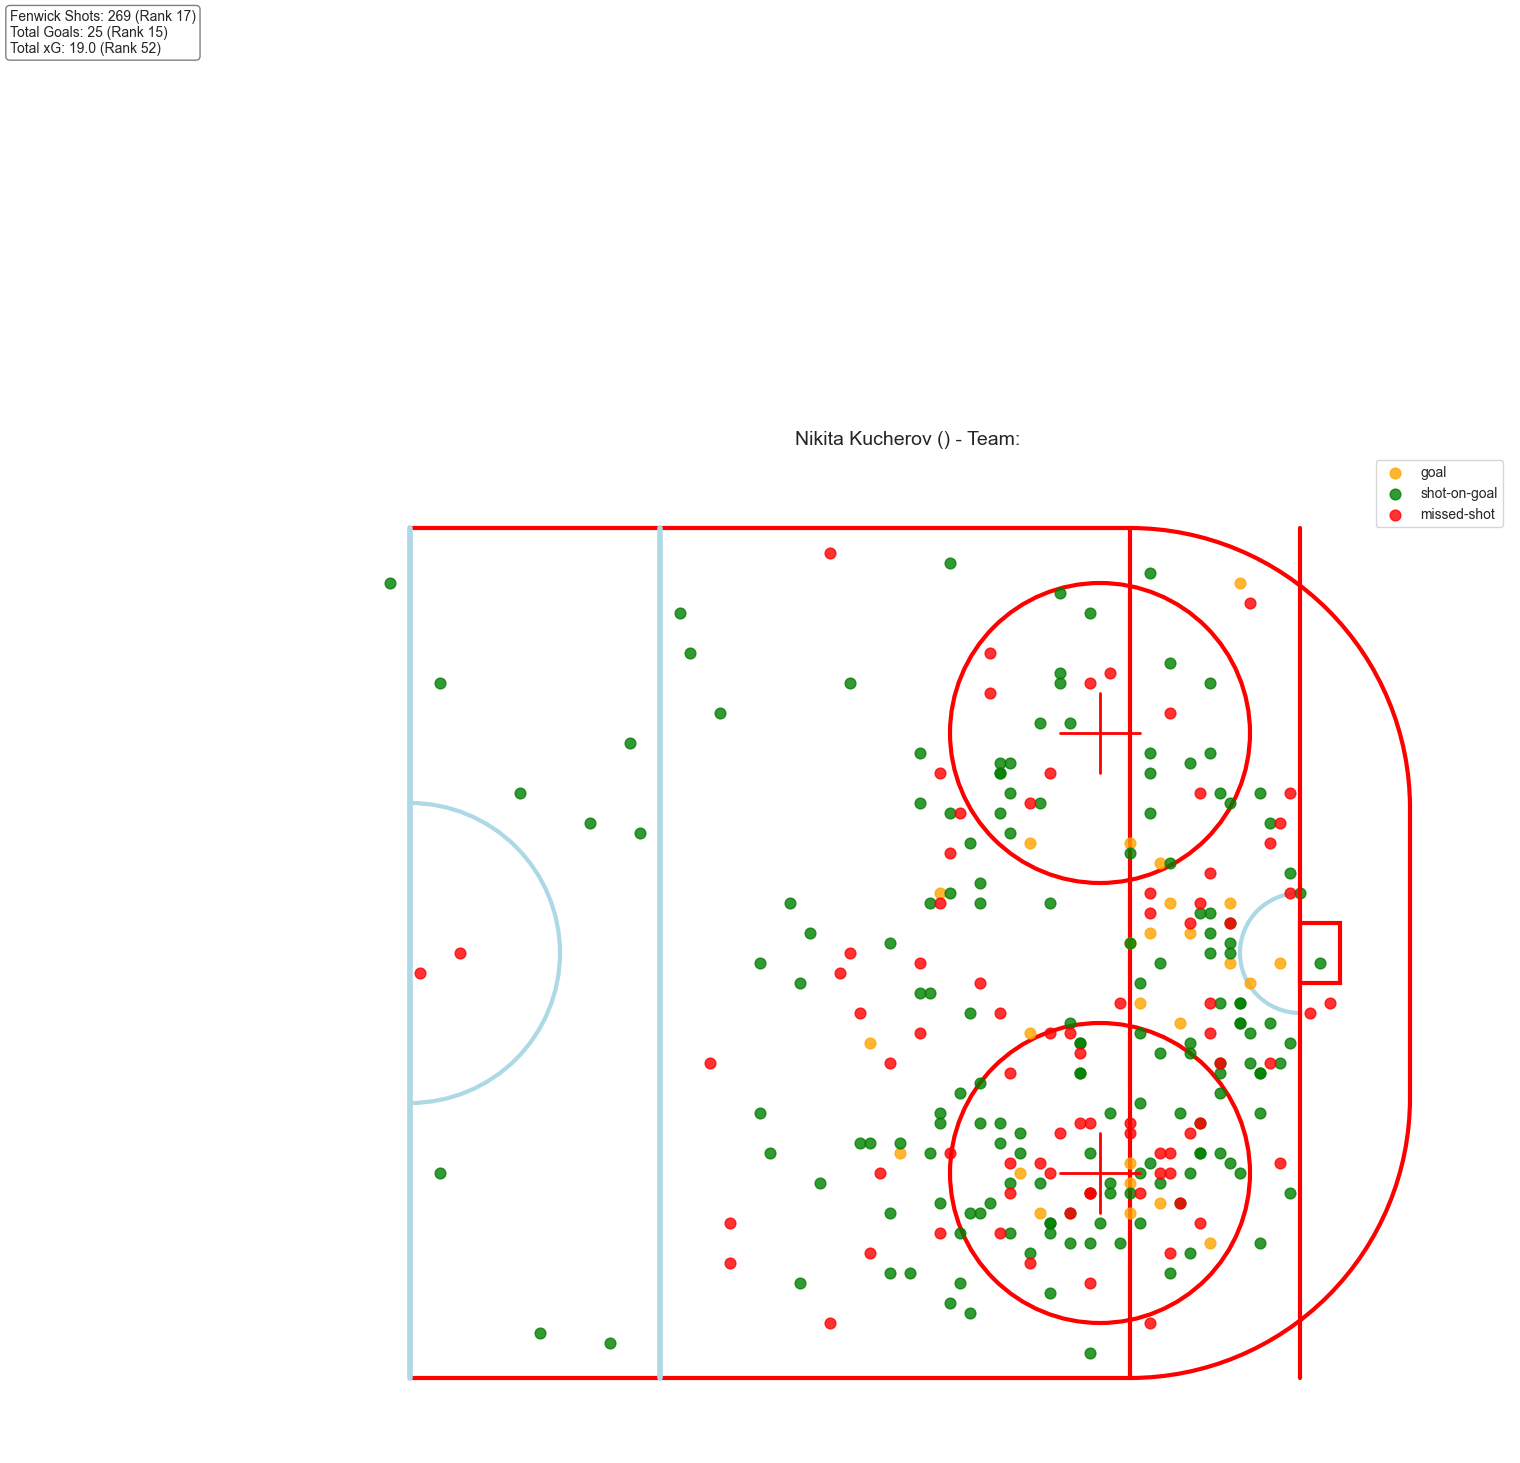

In [79]:
# 4. Grpah each player's shot location on ice 

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc

def draw_half_nhl_rink(ax=None):
    """
    Draw a stylized half NHL rink (white background, red boundary),
    with:
      • A "blue line" at x=0 (light blue)
      • Red boundary & corner arcs
      • Red end-zone faceoff circles
      • A light-blue partial center circle at (0,0)
      • A light-blue goal crease arc (opening to the left)
      • A red net at x=89
    Dimensions (in feet): x=0..100, y=-42.5..42.5
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,10))
    else:
        fig = ax.get_figure()

    # Turn off axes, keep white background
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_xlim(-10, 110)
    ax.set_ylim(-50, 50)

    # --- Main white rink area with red boundary ---
    main_rink = Rectangle(
        (0, -42.5),
        72,
        85,
        facecolor='white',
        edgecolor='red',
        linewidth=3
    )
    ax.add_patch(main_rink)

    # Corner arcs
    corner_arc_top = Arc((72, 14.5), 56, 56, theta1=0, theta2=90,
                         edgecolor='red', linewidth=3)
    ax.add_patch(corner_arc_top)
    corner_arc_bottom = Arc((72, -14.5), 56, 56, theta1=-90, theta2=0,
                            edgecolor='red', linewidth=3)
    ax.add_patch(corner_arc_bottom)

    # End boards at x=100
    ax.plot([100, 100], [14.5, -14.5], color='red', linewidth=3)

    # "Blue line" at x=0 (light blue)
    ax.plot([0, 0], [-42.5, 42.5], color='#ADD8E6', linewidth=4) 

     # "Blue line" at x=25 (light blue)
    ax.plot([25, 25], [-42.5, 42.5], color='#ADD8E6', linewidth=4) 

    # Partial center circle (light blue)
    center_circle = Arc((0, 0), 30, 30, theta1=270, theta2=90,
                        edgecolor='#ADD8E6', linewidth=3)
    ax.add_patch(center_circle)

    # Goal line at x=89
    ax.plot([89, 89], [-42.5, 42.5], color='red', linewidth=3)

    # End-zone faceoff circles (red)
    circle_top = Circle((69, 22), 15, facecolor='none', edgecolor='red', linewidth=3)
    circle_bottom = Circle((69, -22), 15, facecolor='none', edgecolor='red', linewidth=3)
    ax.add_patch(circle_top)
    ax.add_patch(circle_bottom)

    # Crosshairs in faceoff circles
    cross_len = 4
    for y_center in [22, -22]:
        ax.plot([69 - cross_len, 69 + cross_len], [y_center, y_center],
                color='red', linewidth=2)
        ax.plot([69, 69], [y_center - cross_len, y_center + cross_len],
                color='red', linewidth=2)

    # Goal crease (light blue arc), opening left
    crease = Arc((89, 0), 12, 12, theta1=90, theta2=270,
                 edgecolor='#ADD8E6', linewidth=3)
    ax.add_patch(crease)

    # Net (red rectangle)
    net = Rectangle((89, -3), 4, 6, facecolor='none',
                    edgecolor='red', linewidth=3)
    ax.add_patch(net)

    return ax


def plot_player_shots(df, df_players, player_id):
    # 1) Merge data with player info
    df_merged = pd.merge(
        df,
        df_players[['playerId', 'Player', 'Position']],  # add more if needed (e.g. Team)
        left_on='Player1',
        right_on='playerId',
        how='left'
    )

    # 2) Compute per-player totals (to get ranks)
    grouped = df_merged.groupby('Player1').agg(
        total_goals=('Event', lambda x: (x == 'goal').sum()),
        total_shots=('Event', lambda x: (x == 'shot-on-goal').sum()),
        total_missed=('Event', lambda x: (x == 'missed-shot').sum()),
        total_xg=('xG', 'sum')
    ).reset_index()
    grouped['fenwick_shots'] = grouped['total_goals'] + grouped['total_shots'] + grouped['total_missed']

    # Rank (descending = best rank = 1)
    grouped['goals_rank'] = grouped['total_goals'].rank(method='min', ascending=False)
    grouped['fenwick_rank'] = grouped['fenwick_shots'].rank(method='min', ascending=False)
    grouped['xg_rank'] = grouped['total_xg'].rank(method='min', ascending=False)

    # 3) Filter the main data for the chosen player
    df_player = df_merged[df_merged['Player1'] == player_id].copy()
    if df_player.empty:
        print(f"No shots found for playerId={player_id}. Check your data.")
        return

    # Extract some info for the chosen player
    player_name = df_player['Player'].iloc[0]
    position = df_player['Position'].iloc[0] if 'Position' in df_player.columns else ""
    team = df_player['Team'].iloc[0] if 'Team' in df_player.columns else ""

    # 4) Summaries for the chosen player
    total_goals = (df_player['Event'] == 'goal').sum()
    total_shots = (df_player['Event'] == 'shot-on-goal').sum()
    total_missed = (df_player['Event'] == 'missed-shot').sum()
    fenwick_shots = total_goals + total_shots + total_missed
    total_xg = df_player['xG'].sum()

    # Pull the player's rank
    player_stats = grouped[grouped['Player1'] == player_id].squeeze()
    goals_rank = int(player_stats['goals_rank'])
    fenwick_rank = int(player_stats['fenwick_rank'])
    xg_rank = int(player_stats['xg_rank'])

    # 5) Plot the half rink
    fig, ax = plt.subplots(figsize=(12,10))
    draw_half_nhl_rink(ax=ax)

    # Map event type -> color
    color_map = {
        'goal': 'orange',
        'shot-on-goal': 'green',
        'missed-shot': 'red'
    }

    # Scatter each event type
    for evt_type, c in color_map.items():
        df_evt = df_player[df_player['Event'] == evt_type]
        ax.scatter(df_evt['X'], df_evt['Y'], s=60, c=c, alpha=0.8, label=evt_type)

    # Title
    title_str = f"{player_name} ({position}) - Team: {team}"
    ax.set_title(title_str, fontsize=14)

    # 6) Summary text with ranks
    summary_str = (
        f"Fenwick Shots: {fenwick_shots} (Rank {fenwick_rank})\n"
        f"Total Goals: {total_goals} (Rank {goals_rank})\n"
        f"Total xG: {total_xg:.1f} (Rank {xg_rank})"
    )
    ax.text(
        -40, 90, summary_str, fontsize=10,
        bbox=dict(boxstyle="round", fc="white", ec="gray")
    )

    # Legend
    ax.legend(loc="upper right")

    # --- Remove margins & whitespace ---
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    # or equivalently: fig.tight_layout(pad=0)

    plt.show()

# Example usage
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')
    df_players = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')

    # Ask user for a player ID
    player_id_to_plot = input("Enter a playerId: ")
    try:
        player_id_to_plot = int(player_id_to_plot)
    except ValueError:
        print("Invalid input. Please enter a valid integer.")
        exit()

    # Plot
    plot_player_shots(df, df_players, player_id_to_plot)


In [34]:
# Block 8: 
# How do we account for shooters' talent? 
# Idea 1: Shooting Percentage:  S% 

import pandas as pd

# 1. Read the xG results
df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')

# 2. Filter rows to include shot attempts: 
#    Include events that are 'shot-on-goal' OR where a goal was scored.
df_shots = df_xg[(df_xg['Event'] == 'shot-on-goal') | (df_xg['Goal'] == 1)]

# 3. Group by Player1 to compute total shot attempts and total goals
df_shooting = (
    df_shots.groupby('Player1', as_index=False)
            .agg(
                Attempts=('Event', 'count'),  # counts all shot attempts
                Goals=('Goal', 'sum')           # sums the Goal column (assumes 1 = goal, 0 otherwise)
            )
)

# 4. Calculate shooting percentage (Goals divided by total attempts)
df_shooting['Shooting_Percentage'] = df_shooting['Goals'] / df_shooting['Attempts']

# 5. Read the player CSV to bring in player names
df_players = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')

# 6. Merge the shooting stats with the player info
df_merged_shooting = pd.merge(
    df_shooting,
    df_players[['playerId', 'Player']],
    left_on='Player1',
    right_on='playerId',
    how='left'
)

# 7. Sort by shooting percentage (descending) and select the top 20
df_top10 = df_merged_shooting.sort_values('Shooting_Percentage', ascending=False).head(20)

# Optional: Print the top 20 results to check
print(df_top10)

# 8. Export the complete merged shooting data and top 20 to CSV files for R analysis
df_merged_shooting.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/merged_shooting.csv', index=False)

     Player1  Attempts  Goals  Shooting_Percentage  playerId  \
119  8475958         1      1             1.000000   8475958   
735  8482663         1      1             1.000000   8482663   
342  8478430         2      1             0.500000   8478430   
822  8484135         2      1             0.500000   8484135   
673  8482088         2      1             0.500000   8482088   
448  8479550         2      1             0.500000   8479550   
780  8483429         9      4             0.444444   8483429   
297  8477993        13      5             0.384615   8477993   
765  8482787         6      2             0.333333   8482787   
713  8482192         3      1             0.333333   8482192   
777  8483398         3      1             0.333333   8483398   
258  8477511        16      5             0.312500   8477511   
798  8483489        19      5             0.263158   8483489   
278  8477944        28      7             0.250000   8477944   
310  8478056         4      1           

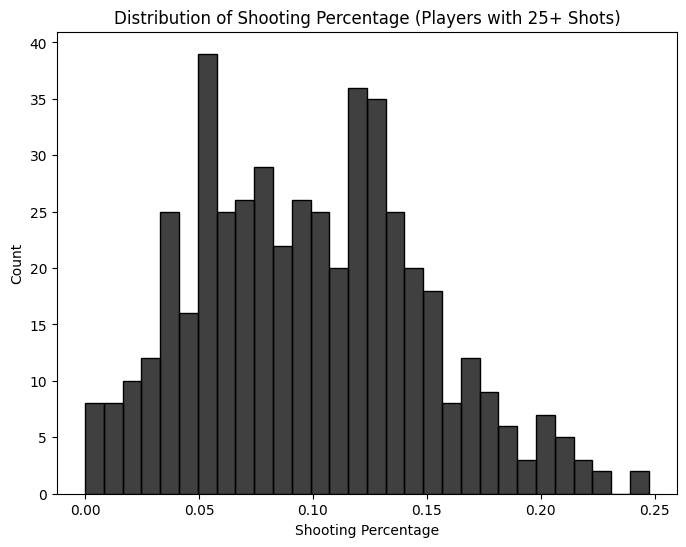

Number of players in the filtered dataset: 482


In [35]:
# Graph its distribution 

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter out players with fewer than 25 shots
df_filtered = df_shooting[df_shooting['Attempts'] >= 50] 

# 2. Plot the histogram of shooting percentage for the filtered data
plt.figure(figsize=(8, 6))
sns.histplot(data=df_filtered, x='Shooting_Percentage', bins=30, color='black', kde=False)
plt.xlabel('Shooting Percentage')
plt.ylabel('Count')
plt.title('Distribution of Shooting Percentage (Players with 25+ Shots)')
plt.show()

print("Number of players in the filtered dataset:", len(df_filtered))

Estimated α (alpha): 0.9184
Estimated β (beta):  9.3486


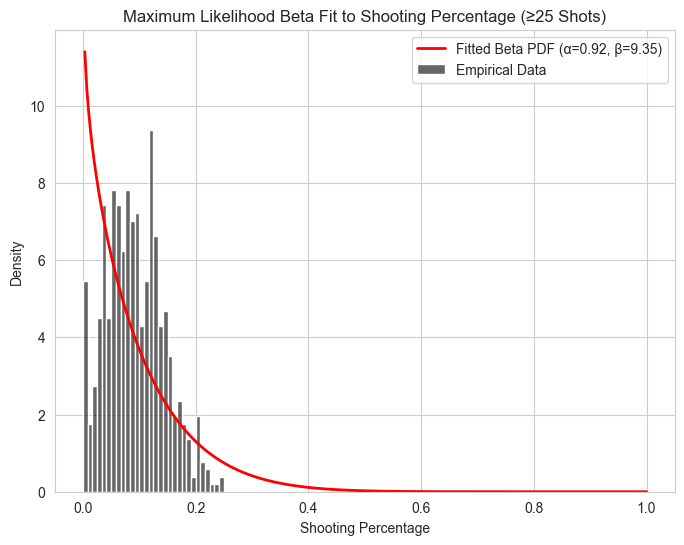

In [124]:
# Method of Max Likelihood 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

# 1. Filter out players with fewer than 25 shots
df_filtered = df_shooting[df_shooting['Attempts'] >= 25]

# 2. Extract shooting percentage values and ensure they are strictly between 0 and 1
shooting_perc = df_filtered['Shooting_Percentage'].values
shooting_perc = np.clip(shooting_perc, 1e-6, 1 - 1e-6)

# 3. Estimate Beta distribution parameters using Maximum Likelihood
alpha_mle, beta_mle, loc, scale = beta.fit(shooting_perc, floc=0, fscale=1)
print(f"Estimated α (alpha): {alpha_mle:.4f}")
print(f"Estimated β (beta):  {beta_mle:.4f}")

# 4. Plot the histogram of shooting percentages and overlay the fitted Beta PDF
plt.figure(figsize=(8, 6))
sns.histplot(shooting_perc, stat='density', bins=30, color='black', alpha=0.6, label='Empirical Data')

# Generate a smooth x-axis from 0 to 1
x = np.linspace(0, 1, 300)
pdf_vals = beta.pdf(x, alpha_mle, beta_mle, loc=0, scale=1)

plt.plot(x, pdf_vals, 'r-', lw=2, label=f'Fitted Beta PDF (α={alpha_mle:.2f}, β={beta_mle:.2f})')
plt.xlabel("Shooting Percentage")
plt.ylabel("Density")
plt.title("Maximum Likelihood Beta Fit to Shooting Percentage (≥25 Shots)")
plt.legend()
plt.show()


Method-of-Moments Estimate for Beta distribution:
Alpha (α) = 2.8452
Beta  (β) = 27.9255


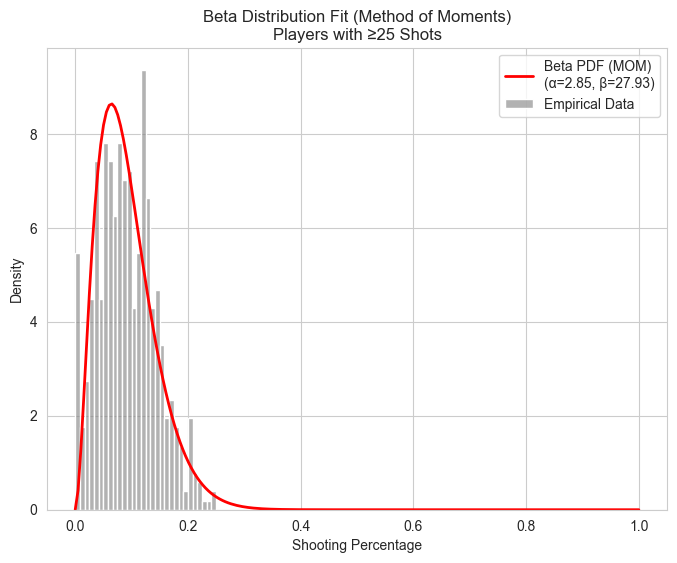

Number of players in the filtered dataset: 615
95% coverage interval of fitted Beta: [0.019, 0.215]
Percentage of data within this interval: 91.71%


In [83]:
# Method of Moments 
# MOM formulas for Beta distribution:
#   α = mean * (mean*(1-mean)/variance - 1)
#   β = (1-mean) * (mean*(1-mean)/variance - 1)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

df_filtered = df_shooting[df_shooting['Attempts'] >= 25]

# Extract shooting percentages
shooting_perc = df_filtered['Shooting_Percentage'].values

# If you have exact 0 or 1 values, clip them slightly inside (0,1)
shooting_perc = np.clip(shooting_perc, 1e-6, 1 - 1e-6)

mean_ = np.mean(shooting_perc)
var_ = np.var(shooting_perc, ddof=1)  # sample variance with Bessel's correction

# α_mom and β_mom
alpha_mom = mean_ * ((mean_ * (1 - mean_)) / var_ - 1)
beta_mom = (1 - mean_) * ((mean_ * (1 - mean_)) / var_ - 1)

print("Method-of-Moments Estimate for Beta distribution:")
print(f"Alpha (α) = {alpha_mom:.4f}")
print(f"Beta  (β) = {beta_mom:.4f}")

plt.figure(figsize=(8, 6))

# Histogram of empirical data (density-scaled)
sns.histplot(shooting_perc, stat='density', bins=30, color='gray', alpha=0.6, label='Empirical Data')

# Generate x-values and Beta PDF using the MOM parameters
x = np.linspace(0, 1, 200)
pdf_vals = beta.pdf(x, alpha_mom, beta_mom)

plt.plot(x, pdf_vals, 'r-', lw=2, 
         label=f'Beta PDF (MOM)\n(α={alpha_mom:.2f}, β={beta_mom:.2f})')

plt.xlabel('Shooting Percentage')
plt.ylabel('Density')
plt.title('Beta Distribution Fit (Method of Moments)\nPlayers with ≥25 Shots')
plt.legend()
plt.show()

# Filter out players with fewer than 25 shots
df_filtered = df_shooting[df_shooting['Attempts'] >= 25]

# Print how many players remain
print(f"Number of players in the filtered dataset: {df_filtered.shape[0]}")


# 4. Compute the 95% coverage interval of the fitted Gamma
lower_95 = beta.ppf(0.025, alpha_mom, beta_mom)
upper_95 = beta.ppf(0.975, alpha_mom, beta_mom)

# Count how many data points lie within [lower_95, upper_95]
within_95 = np.sum((shooting_perc >= lower_95) & (shooting_perc <= upper_95))
percent_within_95 = within_95 / len(shooting_perc) * 100

print(f"95% coverage interval of fitted Beta: [{lower_95:.3f}, {upper_95:.3f}]")
print(f"Percentage of data within this interval: {percent_within_95:.2f}%")

Estimated parameters for the two-component Beta mixture:
  Mixture weight, w   = 0.0455
  Component 1: α = 1.25, β = 794024.64
  Component 2: α = 3.23, β = 30.13
  Negative log-likelihood: -1214.56


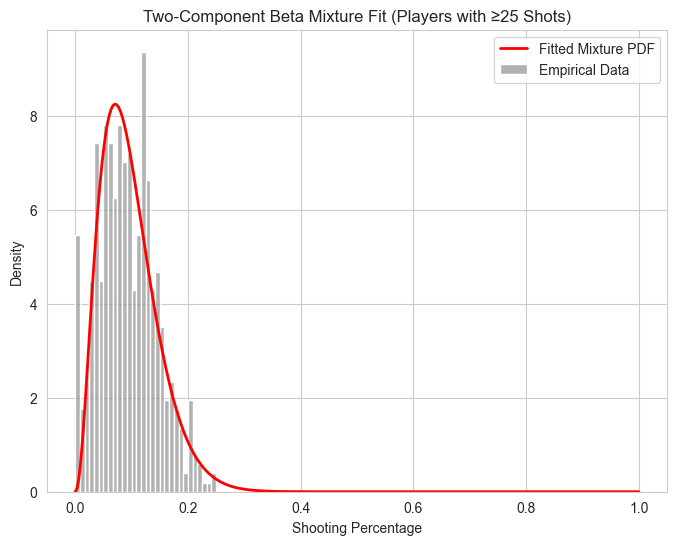

In [84]:
# A subtle second “bump” in the data or a long tail that a single Beta can’t capture, 
# A two‐component Beta mixture can help. In practice:

# Perform multiple random restarts when you do MLE for the mixture. A single run might converge to a degenerate solution.
# Check if you need zero‐inflation. 
# If a notable fraction of players have extremely low (near‐zero) shooting percentages, 
# might add a point mass at zero or use a zero‐inflated Beta mixture.
# If your data truly looks multi‐modal or heavily skewed, you might even consider three Beta components.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from scipy.optimize import minimize

# 1. Data Preparation
# Filter players with at least 25 attempts and clip shooting percentages to (0,1)
df_filtered = df_shooting[df_shooting['Attempts'] >= 25]
shooting_perc = df_filtered['Shooting_Percentage'].values
shooting_perc = np.clip(shooting_perc, 1e-6, 1 - 1e-6)

# 2. Define Negative Log-Likelihood for the Two-Component Beta Mixture
def mixture_beta_nll(params, data):
    """
    Negative log-likelihood for a two-component Beta mixture.
    params = [w, a1, b1, a2, b2]
      where 0 < w < 1, a1, b1, a2, b2 > 0.
    """
    w, a1, b1, a2, b2 = params
    # Check parameter bounds
    if not (0 < w < 1 and a1 > 0 and b1 > 0 and a2 > 0 and b2 > 0):
        return np.inf

    pdf1 = beta.pdf(data, a1, b1)
    pdf2 = beta.pdf(data, a2, b2)
    mix_pdf = w * pdf1 + (1 - w) * pdf2

    # Avoid taking log(0)
    mix_pdf = np.maximum(mix_pdf, 1e-12)
    return -np.sum(np.log(mix_pdf))

# 3. Multi-Start Fitting
best_loss = np.inf
best_params = None

# Try 20 random initializations
n_restarts = 20
for i in range(n_restarts):
    # Generate random initial guesses
    init_params = [
        np.random.uniform(0.3, 0.7),       # w
        np.random.uniform(0.5, 10),          # a1
        np.random.uniform(5, 20),            # b1
        np.random.uniform(0.5, 10),          # a2
        np.random.uniform(5, 20)             # b2
    ]
    bounds = [(1e-6, 1 - 1e-6),   # w: must be in (0,1)
              (1e-6, None),       # a1 > 0
              (1e-6, None),       # b1 > 0
              (1e-6, None),       # a2 > 0
              (1e-6, None)]       # b2 > 0

    result = minimize(mixture_beta_nll, init_params, args=(shooting_perc,),
                      method='L-BFGS-B', bounds=bounds)
    
    if result.fun < best_loss:
        best_loss = result.fun
        best_params = result.x

w_est, a1_est, b1_est, a2_est, b2_est = best_params
print("Estimated parameters for the two-component Beta mixture:")
print(f"  Mixture weight, w   = {w_est:.4f}")
print(f"  Component 1: α = {a1_est:.2f}, β = {b1_est:.2f}")
print(f"  Component 2: α = {a2_est:.2f}, β = {b2_est:.2f}")
print(f"  Negative log-likelihood: {best_loss:.2f}")

# 4. Plot the Histogram and Fitted Mixture PDF
plt.figure(figsize=(8, 6))
# Plot the empirical histogram (density-scaled)
sns.histplot(shooting_perc, stat='density', bins=30, color='gray', alpha=0.6, label='Empirical Data')

# Create an x-axis and compute individual Beta PDFs
x = np.linspace(0, 1, 300)
pdf1 = beta.pdf(x, a1_est, b1_est)
pdf2 = beta.pdf(x, a2_est, b2_est)
pdf_mix = w_est * pdf1 + (1 - w_est) * pdf2

plt.plot(x, pdf_mix, 'r-', lw=2, label='Fitted Mixture PDF')
plt.xlabel('Shooting Percentage')
plt.ylabel('Density')
plt.title('Two-Component Beta Mixture Fit (Players with ≥25 Shots)')
plt.legend()
plt.show()


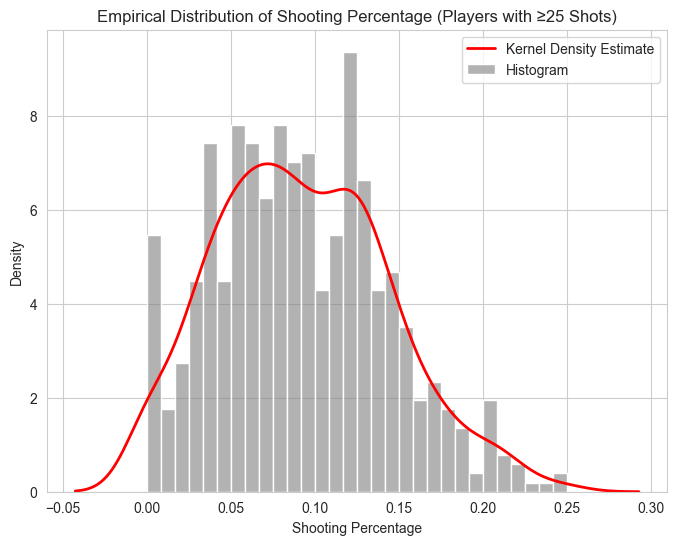

Mean: 0.0925
Median: 0.0889
Std Dev: 0.0514
Min: 0.0000
Max: 0.2500
Coverage of KDE between 0.0000 and 0.2045: 94.53%


In [90]:
# Kernel Density Estimate 
# Instead of assuming your data follows a specific distribution (like a Beta or Gaussian), 
# KDE places a small, smooth function (often a Gaussian "kernel") at each data point 
# and sums them up to create a continuous, smooth approximation of the underlying distribution.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter out players with fewer than 25 attempts
df_filtered = df_shooting[df_shooting['Attempts'] >= 25]

# 2. Extract shooting percentage values
shooting_perc = df_filtered['Shooting_Percentage'].values

# 3. Ensure values are strictly between 0 and 1 (clip if necessary)
shooting_perc = np.clip(shooting_perc, 1e-6, 1 - 1e-6)

# 4. Plot the histogram and the KDE (empirical distribution)
plt.figure(figsize=(8, 6))
sns.histplot(shooting_perc, stat='density', bins=30, color='gray', alpha=0.6, label='Histogram')
sns.kdeplot(shooting_perc, color='red', lw=2, label='Kernel Density Estimate')

plt.xlabel('Shooting Percentage')
plt.ylabel('Density')
plt.title('Empirical Distribution of Shooting Percentage (Players with ≥25 Shots)')
plt.legend()
plt.show()

# Summary Stats for the distribution 
mean_val = np.mean(shooting_perc)
median_val = np.median(shooting_perc)
std_val = np.std(shooting_perc, ddof=1)  # sample std
min_val = np.min(shooting_perc)
max_val = np.max(shooting_perc)

print(f"Mean: {mean_val:.4f}")
print(f"Median: {median_val:.4f}")
print(f"Std Dev: {std_val:.4f}")
print(f"Min: {min_val:.4f}")
print(f"Max: {max_val:.4f}")



from scipy.stats import gaussian_kde

# Fit a KDE using the shooting percentage data
kde = gaussian_kde(shooting_perc)

# Compute the 2.5th and 97.5th percentiles from the data
lower_bound = np.percentile(shooting_perc, 2.5)
upper_bound = np.percentile(shooting_perc, 97.5)

# Numerically integrate the KDE between these bounds
area = kde.integrate_box_1d(lower_bound, upper_bound)

print(f"Coverage of KDE between {lower_bound:.4f} and {upper_bound:.4f}: {area * 100:.2f}%")


In [91]:
# Method of Moments for Beta Prior 

mean_ = 0.0928
std_ = 0.0517
var_ = std_**2

mom_factor = (mean_ * (1 - mean_)) / var_ - 1
alpha_prior = mean_ * mom_factor
beta_prior  = (1 - mean_) * mom_factor

print("Beta Prior (from league distribution):")
print(f"  alpha ~ {alpha_prior:.4f}")
print(f"  beta  ~ {beta_prior:.4f}")


Beta Prior (from league distribution):
  alpha ~ 2.8301
  beta  ~ 27.6669


In [92]:
# Compute Posterior 

# Suppose alpha_prior and beta_prior come from the method-of-moments step above
df_filtered['alpha_post'] = alpha_prior + df_filtered['Goals']
df_filtered['beta_post']  = beta_prior  + (df_filtered['Attempts'] - df_filtered['Goals'])

# Posterior mean (shrunken shooting percentage)
df_filtered['Posterior_Mean'] = (
    df_filtered['alpha_post'] / (df_filtered['alpha_post'] + df_filtered['beta_post'])
)

# Example: Print or inspect the top players by Posterior_Mean
df_filtered.sort_values('Posterior_Mean', ascending=False).head(15) 

/var/folders/mr/6qm9flxx6yx_m92_zh0gvg_c0000gn/T/ipykernel_48398/660343401.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['alpha_post'] = alpha_prior + df_filtered['Goals']
/var/folders/mr/6qm9flxx6yx_m92_zh0gvg_c0000gn/T/ipykernel_48398/660343401.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['beta_post']  = beta_prior  + (df_filtered['Attempts'] - df_filtered['Goals'])
/var/folders/mr/6qm9flxx6yx_m92_zh0gvg_c0000gn/T/ipykernel_48398/660343401.py:8: SettingWithCopyWarning:

,Player1,Attempts,Goals,Shooting_Percentage,alpha_post,beta_post,Posterior_Mean
146,8476460,133,32,0.240602,34.830127,128.666927,0.213032
734,8482660,93,23,0.247312,25.830127,97.666927,0.209156
484,8480014,116,26,0.224138,28.830127,117.666927,0.196797
272,8477934,199,42,0.211055,44.830127,184.666927,0.195341
750,8482720,99,22,0.222222,24.830127,104.666927,0.191743
299,8478010,138,29,0.210145,31.830127,136.666927,0.188906
386,8478874,71,16,0.225352,18.830127,82.666927,0.185524
57,8475168,121,25,0.206612,27.830127,123.666927,0.183701
238,8477476,106,22,0.207547,24.830127,111.666927,0.181910
671,8482079,103,21,0.203883,23.830127,109.666927,0.178507


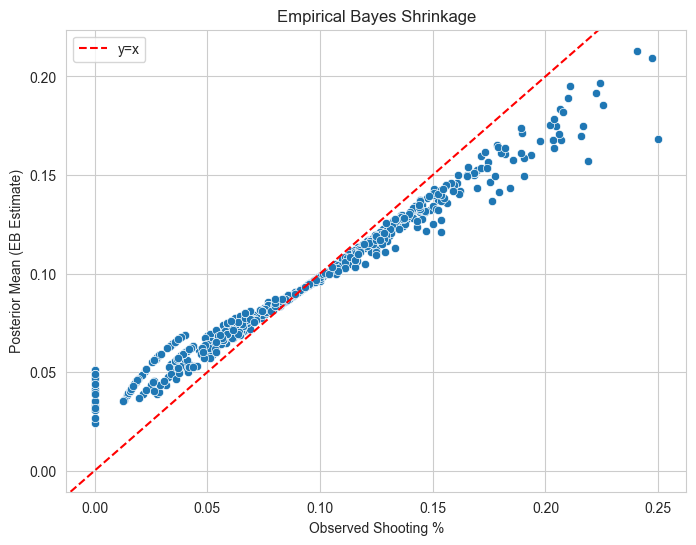

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_filtered, 
    x='Shooting_Percentage', 
    y='Posterior_Mean'
)
plt.xlabel('Observed Shooting %')
plt.ylabel('Posterior Mean (EB Estimate)')
plt.title('Empirical Bayes Shrinkage')
plt.axline((0,0), slope=1, color='red', linestyle='--', label='y=x')
plt.legend()
plt.show()


Beta Prior (from league distribution):
  alpha ~ 2.8301
  beta  ~ 27.6669
Mean League Posterior Shooting %: 0.09451288560916994


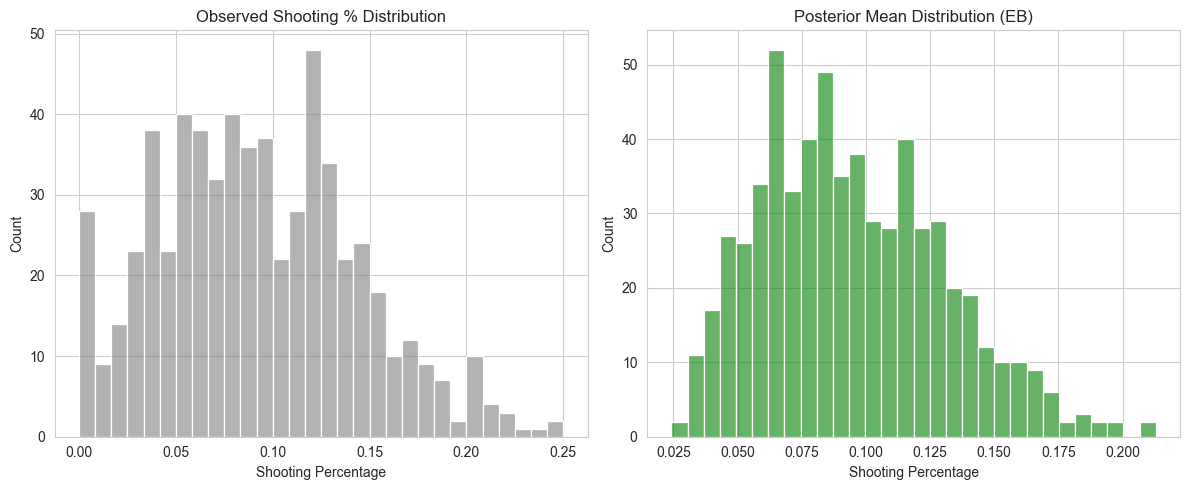

=== Distribution Metrics ===
Observed Shooting %  -> Mean: 0.0925, Std: 0.0514
Posterior Mean (EB)  -> Mean: 0.0945, Std: 0.0357

Correlation (Observed vs. Posterior Mean): 0.9880


In [116]:
# Monte-Carlo Simulation for Posterior from Prior 
# Mean 
# 95% Credible Interval 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

# 1. Read and Process xG Data
# Read xG results
df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')

# Filter rows: include events that are 'shot-on-goal' OR where a goal was scored.
df_shots = df_xg[(df_xg['Event'] == 'shot-on-goal') | (df_xg['Goal'] == 1)]

# Group by Player1 to compute total shot attempts and goals
df_shooting = (
    df_shots.groupby('Player1', as_index=False)
            .agg(
                Attempts=('Event', 'count'),
                Goals=('Goal', 'sum')
            )
)

# Calculate shooting percentage
df_shooting['Shooting_Percentage'] = df_shooting['Goals'] / df_shooting['Attempts']

# 2. Read Players CSV
df_players = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')

# 3. Filter for Players with ≥25 Attempts
df_filtered = df_shooting[df_shooting['Attempts'] >= 25]

# Clip shooting percentages to be strictly in (0,1)
shooting_perc_all = np.clip(df_filtered['Shooting_Percentage'].values, 1e-6, 1-1e-6)

# 4. Define League-Wide Beta Prior via Method-of-Moments
mean_ = 0.0928
std_ = 0.0517
var_ = std_ ** 2
mom_factor = (mean_ * (1 - mean_)) / var_ - 1
alpha_prior = mean_ * mom_factor      # ~2.8301
beta_prior  = (1 - mean_) * mom_factor  # ~27.6669

print("Beta Prior (from league distribution):")
print(f"  alpha ~ {alpha_prior:.4f}")
print(f"  beta  ~ {beta_prior:.4f}")

# -------------------------------
N_sims = 50000  # Number of Monte Carlo draws per player
post_summary = []

for idx, row in df_filtered.iterrows():
    player_id = row['Player1']
    G = row['Goals']
    A = row['Attempts']
    obs_shooting = row['Shooting_Percentage']
    
    # Beta-Binomial conjugate update for the posterior:
    alpha_post = alpha_prior + G
    beta_post  = beta_prior + (A - G)
    
    # Draw samples from the player's Beta posterior distribution
    samples = np.random.beta(alpha_post, beta_post, size=N_sims)
    
    # Compute summary statistics for the posterior
    posterior_mean = np.mean(samples)
    lower_ci = np.percentile(samples, 2.5)
    upper_ci = np.percentile(samples, 97.5)
    
    post_summary.append({
       'Player1': player_id,
       'Attempts': A,
       'Goals': G,
       'Observed_Shooting': obs_shooting,
       'Posterior_Mean': posterior_mean,
       'Lower_CI': lower_ci,
       'Upper_CI': upper_ci
    })

df_post_summary = pd.DataFrame(post_summary)

# 6. Compute and Print the Mean League Posterior Shooting %
mean_league_posterior = df_post_summary['Posterior_Mean'].mean()
print("Mean League Posterior Shooting %:", mean_league_posterior)

# 7. Merge Posterior Results with Players CSV and Create New Columns
df_merged_post = pd.merge(
    df_post_summary,
    df_players[['playerId', 'Player']],
    left_on='Player1',
    right_on='playerId',
    how='left'
)

# Create a new column "Shooting%" using the Posterior Mean
df_merged_post['Shooting%'] = df_merged_post['Posterior_Mean']

# Create a new column "shooter_talent" as the ratio of Posterior Shooting % to league average (mean_)
df_merged_post['shooter_talent'] = df_merged_post['Posterior_Mean'] / mean_

# 8. Save the Updated Results
df_merged_post.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/merged_posteriors.csv', index=False)

# Merge the shooter_talent back into the players CSV and save it
df_players_updated = pd.merge(
    df_players,
    df_merged_post[['playerId', 'shooter_talent']],
    on='playerId',
    how='left'
)
df_players_updated.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/playerstalent.csv', index=False)

# Define df_compare using df_post_summary (which already contains 'Observed_Shooting' and 'Posterior_Mean')
df_compare = df_post_summary.copy()

# Extract the two distributions:
actual_shooting = df_compare['Observed_Shooting'].clip(1e-6, 1-1e-6)
posterior_mean = df_compare['Posterior_Mean']

# 2. Plot side-by-side histograms to compare distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(actual_shooting, bins=30, color='gray', alpha=0.6)
plt.title("Observed Shooting % Distribution")
plt.xlabel("Shooting Percentage")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(posterior_mean, bins=30, color='green', alpha=0.6)
plt.title("Posterior Mean Distribution (EB)")
plt.xlabel("Shooting Percentage")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# 3. Compute basic metrics for each distribution
mean_actual = np.mean(actual_shooting)
std_actual = np.std(actual_shooting, ddof=1)
mean_post = np.mean(posterior_mean)
std_post = np.std(posterior_mean, ddof=1)

print("=== Distribution Metrics ===")
print(f"Observed Shooting %  -> Mean: {mean_actual:.4f}, Std: {std_actual:.4f}")
print(f"Posterior Mean (EB)  -> Mean: {mean_post:.4f}, Std: {std_post:.4f}")

# 4. Compute correlation between Observed and Posterior Means
corr_matrix = np.corrcoef(actual_shooting, posterior_mean)
corr_value = corr_matrix[0, 1]
print(f"\nCorrelation (Observed vs. Posterior Mean): {corr_value:.4f}")

In [117]:
# Print top 10 players with most shooting talent (highest shooter_talent)
top10 = df_merged_post.sort_values(by='shooter_talent', ascending=False).head(15)
print("Top 10 players with most shooting talent:")
print(top10[['Player', 'shooter_talent', 'Posterior_Mean']])


# Print top 10 players with least shooting talent (lowest shooter_talent)
bottom10 = df_merged_post.sort_values(by='shooter_talent', ascending=True).head(15)
print("Top 10 players with least shooting talent:")
print(bottom10[['Player', 'shooter_talent', 'Posterior_Mean']])


# Print summary statistics for 'shooter_talent'
print("Summary statistics for shooter_talent:")
print(df_merged_post['shooter_talent'].describe())

Top 10 players with most shooting talent:
               Player  shooter_talent  Posterior_Mean
115    Mark Scheifele        2.294489        0.212929
564      Kent Johnson        2.253067        0.209085
383   Gabriel Vilardi        2.120073        0.196743
220    Leon Draisaitl        2.105094        0.195353
574     Matthew Knies        2.068112        0.191921
242     Brayden Point        2.035898        0.188931
310     Adam Gaudette        1.999456        0.185550
45       Matt Duchene        1.976943        0.183460
194  Artturi Lehkonen        1.959516        0.181843
523       Marco Rossi        1.922026        0.178364
395       Josh Norris        1.889815        0.175375
236    Ivan Barbashev        1.885191        0.174946
599      Shane Wright        1.881154        0.174571
219      Sam Reinhart        1.874938        0.173994
143        Tom Wilson        1.846599        0.171364
Top 10 players with least shooting talent:
                  Player  shooter_talent  Posterior

                            OLS Regression Results                            
Dep. Variable:         Posterior_Mean   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 2.527e+04
Date:                Thu, 06 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:06:29   Log-Likelihood:                 2329.1
No. Observations:                 615   AIC:                            -4654.
Df Residuals:                     613   BIC:                            -4645.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0311      0.00

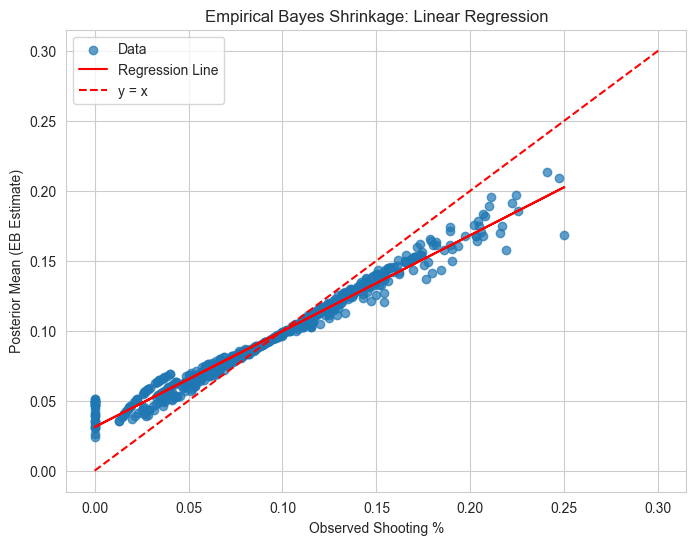

In [96]:
# linear regression for posterior shootint% 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# For convenience, rename for clarity
obs = df_post_summary['Observed_Shooting']
post_mean = df_post_summary['Posterior_Mean']

# 2. Fit a linear regression: Posterior_Mean ~ Observed_Shooting
#    Using statsmodels OLS
X = sm.add_constant(obs)  # adds intercept term
y = post_mean
model = sm.OLS(y, X).fit()

# 3. Print model summary (including R^2)
print(model.summary())

# Extract R-squared explicitly if desired
r_squared = model.rsquared
print(f"R-squared: {r_squared:.4f}")

# 4. Plot the scatter + regression line
plt.figure(figsize=(8,6))
plt.scatter(obs, post_mean, alpha=0.7, label='Data')
plt.plot(obs, model.predict(X), color='red', label='Regression Line')
plt.plot([0, 0.3], [0, 0.3], 'r--', label='y = x')  # optional reference line
plt.xlabel("Observed Shooting %")
plt.ylabel("Posterior Mean (EB Estimate)")
plt.title("Empirical Bayes Shrinkage: Linear Regression")
plt.legend()
plt.show()

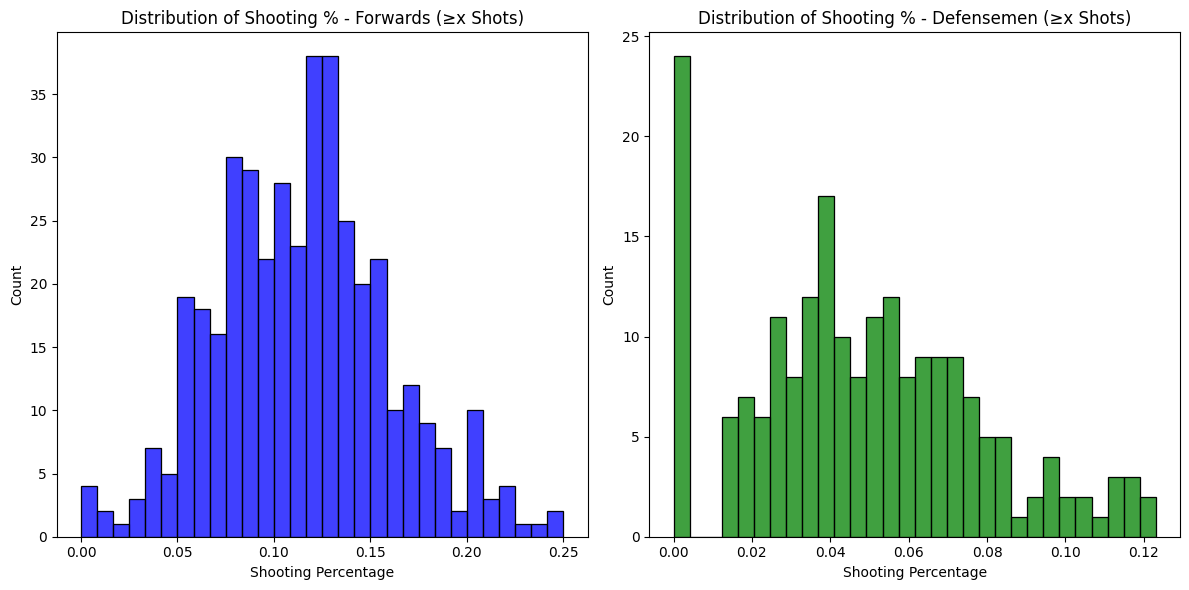

Number of forwards in the filtered dataset: 411
Number of defensemen in the filtered dataset: 204


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read the xG results (includes position column: 'F' or 'D')
df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')

# 2. Filter rows to include shot attempts (shot-on-goal OR Goal=1)
df_shots = df_xg[(df_xg['Event'] == 'shot-on-goal') | (df_xg['Goal'] == 1)]

# 3. Group by Player1 AND position to compute total shot attempts and goals
df_shooting = (
    df_shots.groupby(['Player1', 'Position'], as_index=False)
            .agg(
                Attempts=('Event', 'count'),  # total shot attempts
                Goals=('Goal', 'sum')        # total goals
            )
)

# 4. Calculate shooting percentage
df_shooting['Shooting_Percentage'] = df_shooting['Goals'] / df_shooting['Attempts']

# 6. Filter out players with fewer than 25 attempts
df_filtered = df_shooting[df_shooting['Attempts'] >= 25]

# 7. Separate forwards and defensemen
df_forwards = df_filtered[df_filtered['Position'] == 'F']
df_defense = df_filtered[df_filtered['Position'] == 'D']

# 8. Plot side-by-side histograms
plt.figure(figsize=(12, 6))

# --- Forwards ---
plt.subplot(1, 2, 1)
sns.histplot(data=df_forwards, x='Shooting_Percentage', bins=30, color='blue', kde=False)
plt.title("Distribution of Shooting % - Forwards (≥x Shots)")
plt.xlabel("Shooting Percentage")
plt.ylabel("Count")

# --- Defensemen ---
plt.subplot(1, 2, 2)
sns.histplot(data=df_defense, x='Shooting_Percentage', bins=30, color='green', kde=False)
plt.title("Distribution of Shooting % - Defensemen (≥x Shots)")
plt.xlabel("Shooting Percentage")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# 9. Print how many forwards/defensemen
print("Number of forwards in the filtered dataset:", len(df_forwards))
print("Number of defensemen in the filtered dataset:", len(df_defense))

Top 20 players by total xG and their Shot Ratio (players with at least 5 goals):
     Player1             Player   Total_xG  Total_Goals  Shot_Ratio
298  8477993    Justin Kirkland   1.358428            5    3.680724
333  8478407         Vince Dunn   4.226947           11    2.602351
259  8477511     Anthony Mantha   2.076069            5    2.408398
739  8482660       Kent Johnson   9.642440           23    2.385288
279  8477944        Jakub Vrana   3.060306            7    2.287353
211  8477220       Nate Schmidt   2.319277            5    2.155844
179  8476882   Teuvo Teravainen   7.509018           16    2.130771
138  8476441     Joel Edmundson   2.436876            5    2.051807
412  8479339       Patrik Laine   7.507041           15    1.998124
508  8480145         Neal Pionk   4.508778            9    1.996106
99   8475764         Cam Fowler   3.583281            7    1.953517
388  8478874      Adam Gaudette   8.366756           16    1.912330
184  8476892     Colton Parayko   7

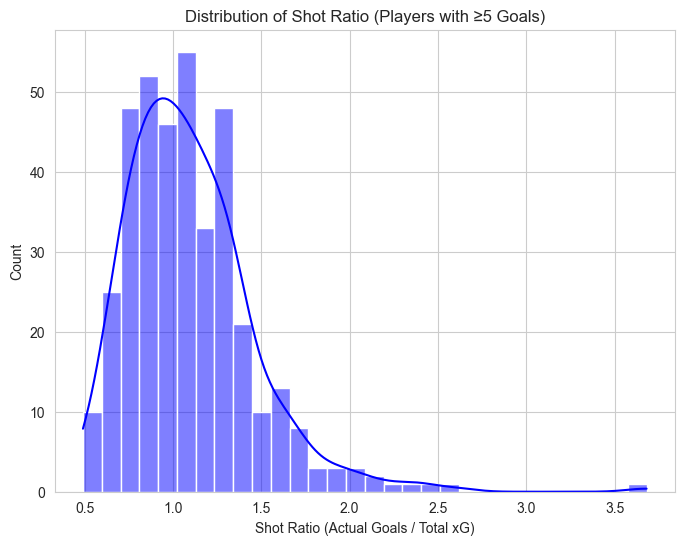

Summary statistics for Shot Ratio:
count    385.000000
mean       1.097141
std        0.365445
min        0.490287
25%        0.853900
50%        1.045248
75%        1.283414
max        3.680724
Name: Shot_Ratio, dtype: float64


In [120]:
# Idea 2: Ratio bewteen   Actual Goal:xG     called   Shot Ratio 

df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv')   

# 2. Compute total xG per player (Player1)
df_player_xg = (
    df_xg.groupby('Player1', as_index=False)
         .agg({'xG': 'sum', 'Goal': 'sum'})
         .rename(columns={'xG': 'Total_xG', 'Goal': 'Total_Goals'})
)

# 3. Read the player CSV
df_players = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')  

# 4. Merge the total xG with the player info
df_merged = pd.merge(
    df_player_xg, 
    df_players[['playerId','Player']],  # or more columns if needed
    left_on='Player1',
    right_on='playerId',
    how='left'
)

# 5. Exclude all players with less than 5 goals
df_merged = df_merged[df_merged['Total_Goals'] >= 5]

# 6. Create a new column "Shot_Ratio" as the ratio of Actual Goals to Total xG
df_merged['Shot_Ratio'] = df_merged['Total_Goals'] / df_merged['Total_xG']

# 7. Sort descending by Total_xG and select top 20 players (optional)
df_top20 = df_merged.sort_values("Shot_Ratio", ascending=False).head(25)

print("Top 20 players by total xG and their Shot Ratio (players with at least 5 goals):")
print(df_top20[['Player1', 'Player', 'Total_xG', 'Total_Goals', 'Shot_Ratio']])

# 8. Graph the distribution of the Shot Ratio
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(data=df_merged, x='Shot_Ratio', bins=30, color='blue', kde=True)
plt.xlabel("Shot Ratio (Actual Goals / Total xG)")
plt.ylabel("Count")
plt.title("Distribution of Shot Ratio (Players with ≥5 Goals)")
plt.show()


# Print summary statistics for 'Shot Ratio'
print("Summary statistics for Shot Ratio:")
print(df_merged['Shot_Ratio'].describe())

Fitted Beta prime parameters:
  alpha = 22.3178
  beta  = 21.3727
  loc   = 0.0000
  scale = 1.0000


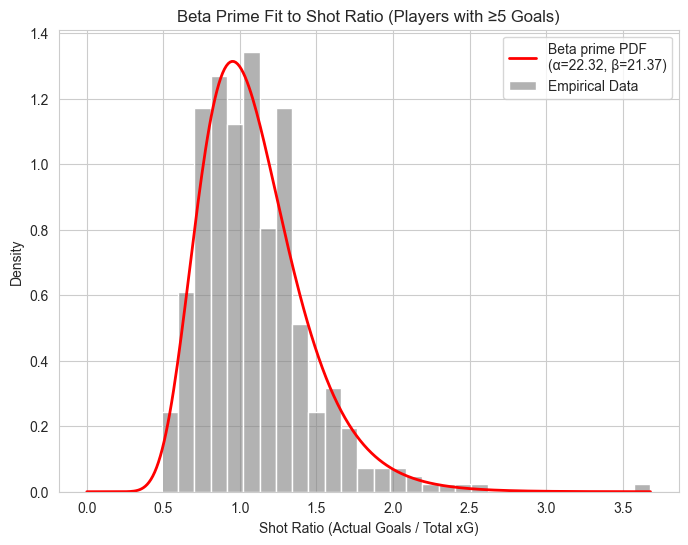

95% coverage interval of fitted Gamma: [0.574, 1.908]
Percentage of data within this interval: 94.81%


In [110]:
# Beta Prime Distribution 
# The distribution handles values in  (0, infinity) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import betaprime

# Suppose df_merged has the column 'Shot_Ratio' (0 < ratio < ~3.5)
# Filter out or clip any ratio <= 0 if it exists
shot_ratio = df_merged['Shot_Ratio'].values
shot_ratio = shot_ratio[shot_ratio > 0]  # ensure positivity

# Fit a Beta prime distribution (MLE) via SciPy
# pin loc=0 to keep it on (0,∞)
alpha_mle, beta_mle, loc_mle, scale_mle = betaprime.fit(shot_ratio, floc=0, fscale=1)
print(f"Fitted Beta prime parameters:")
print(f"  alpha = {alpha_mle:.4f}")
print(f"  beta  = {beta_mle:.4f}")
print(f"  loc   = {loc_mle:.4f}")
print(f"  scale = {scale_mle:.4f}")

# Plot histogram + fitted Beta prime PDF
plt.figure(figsize=(8, 6))
sns.histplot(shot_ratio, stat='density', bins=30, color='gray', alpha=0.6, label='Empirical Data')

x = np.linspace(0.001, shot_ratio.max(), 300)
pdf_vals = betaprime.pdf(x, alpha_mle, beta_mle, loc=loc_mle, scale=scale_mle)

plt.plot(x, pdf_vals, 'r-', lw=2, label=f'Beta prime PDF\n(α={alpha_mle:.2f}, β={beta_mle:.2f})')
plt.xlabel("Shot Ratio (Actual Goals / Total xG)")
plt.ylabel("Density")
plt.title("Beta Prime Fit to Shot Ratio (Players with ≥5 Goals)")
plt.legend()
plt.show()

# 4. Compute the 95% coverage interval of the fitted Gamma
lower_95 = betaprime.ppf(0.025, alpha_mle, beta_mle, loc=loc_mle, scale=scale_mle)
upper_95 = betaprime.ppf(0.975, alpha_mle, beta_mle, loc=loc_mle, scale=scale_mle)

# Count how many data points lie within [lower_95, upper_95]
within_95 = np.sum((shot_ratio >= lower_95) & (shot_ratio <= upper_95))
percent_within_95 = within_95 / len(shot_ratio) * 100

print(f"95% coverage interval of fitted Gamma: [{lower_95:.3f}, {upper_95:.3f}]")
print(f"Percentage of data within this interval: {percent_within_95:.2f}%")

Gamma fit: alpha=10.4884, loc=0.0000, scale=0.1046
Fitted Gamma parameters:
  alpha = 10.4884
  loc   = 0.0000
  scale = 0.1046


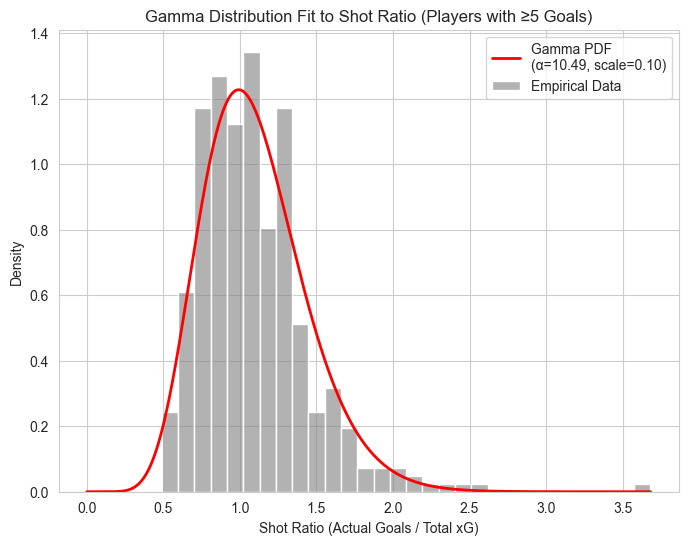

95% coverage interval of fitted Gamma: [0.537, 1.854]
Percentage of data within this interval: 95.32%


In [125]:
# Gamma Distribution 

from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract your Shot Ratio data from df_merged and ensure only positive values are used
shot_ratio = df_merged['Shot_Ratio'].values
shot_ratio = shot_ratio[shot_ratio > 0]

# Fit a Gamma distribution (MLE) with loc pinned to 0
alpha_g, loc_g, scale_g = gamma.fit(shot_ratio, floc=0)
print(f"Gamma fit: alpha={alpha_g:.4f}, loc={loc_g:.4f}, scale={scale_g:.4f}")
print("Fitted Gamma parameters:")
print(f"  alpha = {alpha_g:.4f}")
print(f"  loc   = {loc_g:.4f}")
print(f"  scale = {scale_g:.4f}")

# Plot the histogram (density-scaled) of the empirical data
plt.figure(figsize=(8, 6))
sns.histplot(shot_ratio, stat='density', bins=30, color='gray', alpha=0.6, label='Empirical Data')

# Generate a smooth x-axis from near 0 to the maximum observed value
x = np.linspace(0.001, shot_ratio.max(), 300)
pdf_vals = gamma.pdf(x, alpha_g, loc=loc_g, scale=scale_g)

# Plot the fitted Gamma PDF
plt.plot(x, pdf_vals, 'r-', lw=2, label=f'Gamma PDF\n(α={alpha_g:.2f}, scale={scale_g:.2f})')
plt.xlabel("Shot Ratio (Actual Goals / Total xG)")
plt.ylabel("Density")
plt.title("Gamma Distribution Fit to Shot Ratio (Players with ≥5 Goals)")
plt.legend()
plt.show()

# Compute the 95% coverage interval of the fitted Gamma distribution
lower_95 = gamma.ppf(0.025, alpha_g, loc=loc_g, scale=scale_g)
upper_95 = gamma.ppf(0.975, alpha_g, loc=loc_g, scale=scale_g)

# Count how many data points lie within the interval [lower_95, upper_95]
within_95 = np.sum((shot_ratio >= lower_95) & (shot_ratio <= upper_95))
percent_within_95 = within_95 / len(shot_ratio) * 100

print(f"95% coverage interval of fitted Gamma: [{lower_95:.3f}, {upper_95:.3f}]")
print(f"Percentage of data within this interval: {percent_within_95:.2f}%")


Fitted Gamma Prior:
  alpha_prior = 10.4884
  scale_prior = 0.1046
Top 15 Players by Posterior Shooting Talent (Gamma Posterior Mean):
               Player   Total_xG  Total_Goals  Shot_Ratio  posterior_shooting
739      Kent Johnson   9.642440           23    2.385288            1.743987
333        Vince Dunn   4.226947           11    2.602351            1.558632
179  Teuvo Teravainen   7.509018           16    2.130771            1.551863
273    Leon Draisaitl  24.999997           42    1.680000            1.518772
412      Patrik Laine   7.507041           15    1.998124            1.493449
388     Adam Gaudette   8.366756           16    1.912330            1.477610
184    Colton Parayko   7.354609           14    1.903568            1.447787
57       Matt Duchene  15.013234           25    1.665198            1.444203
3       Alex Ovechkin  14.369229           24    1.670236            1.441281
147    Mark Scheifele  20.119030           32    1.590534            1.431608
440    

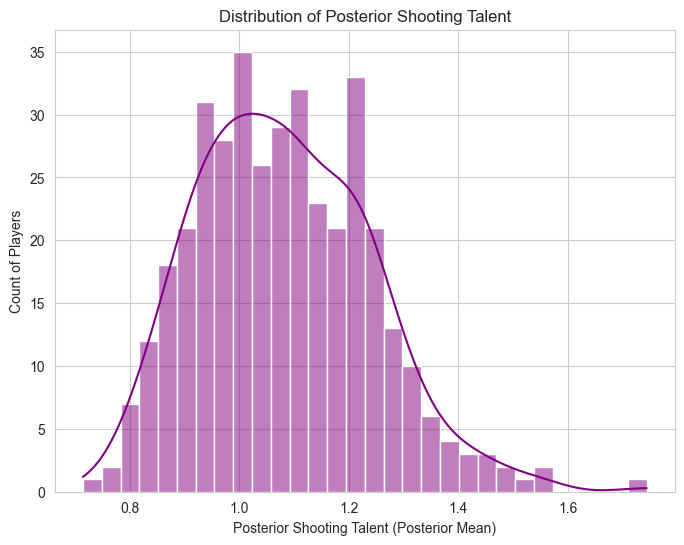

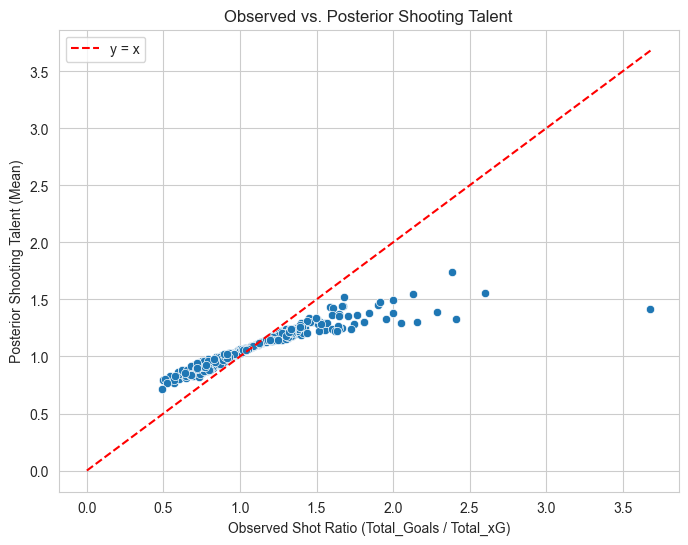

In [113]:
# Compute the Posterior for Each Player via Monte Carlo Simulation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma

# For a Poisson likelihood with mean = theta * Total_xG and Gamma prior Gamma(alpha_prior, scale_prior),
# the conjugate posterior is Gamma(alpha_post, rate_post) where:
#    alpha_post = alpha_prior + Total_Goals
#    rate_post = (1/scale_prior) + Total_xG

# In scale-parameterization: scale_post = 1 / rate_post = scale_prior / (1 + scale_prior * Total_xG)

# The posterior mean is:
#    posterior_mean = alpha_post * scale_post

# 1. Fit a Gamma prior to the overall Shot Ratio data
shot_ratio_all = df_merged['Shot_Ratio'].values
shot_ratio_all = shot_ratio_all[shot_ratio_all > 0]  # ensure only positive values

# Fit Gamma distribution (MLE) with loc fixed to 0
alpha_prior, loc_prior, scale_prior = gamma.fit(shot_ratio_all, floc=0)
print("Fitted Gamma Prior:")
print(f"  alpha_prior = {alpha_prior:.4f}")
print(f"  scale_prior = {scale_prior:.4f}")

# Posterior Calculations 
posterior_means = []
for idx, row in df_merged.iterrows():
    T = row['Total_xG']
    G = row['Total_Goals']
    alpha_post = alpha_prior + G
    scale_post = scale_prior / (1 + scale_prior * T)
    post_mean = alpha_post * scale_post
    posterior_means.append(post_mean)

df_merged['posterior_shooting'] = posterior_means

# 3. Monte Carlo Simulation: Draw samples from each player's posterior
N_sims = 50000
posterior_samples = {}
for idx, row in df_merged.iterrows():
    T = row['Total_xG']
    G = row['Total_Goals']
    alpha_post = alpha_prior + G
    scale_post = scale_prior / (1 + scale_prior * T)
    samples = np.random.gamma(alpha_post, scale_post, size=N_sims)
    posterior_samples[row['Player1']] = samples

# 4. Print Top 15 Players by Posterior Shooting Talent (Gamma Posterior Mean)
df_top15_post = df_merged.sort_values('posterior_shooting', ascending=False).head(15)
print("Top 15 Players by Posterior Shooting Talent (Gamma Posterior Mean):")
print(df_top15_post[['Player', 'Total_xG', 'Total_Goals', 'Shot_Ratio', 'posterior_shooting']])

# 5. Graph the Distribution of Posterior Shooting Talent
plt.figure(figsize=(8, 6))
sns.histplot(df_merged['posterior_shooting'], bins=30, color='purple', kde=True)
plt.xlabel("Posterior Shooting Talent (Posterior Mean)")
plt.ylabel("Count of Players")
plt.title("Distribution of Posterior Shooting Talent")
plt.show()

# 6. Scatter Plot: Observed Shot Ratio vs. Posterior Shooting Talent
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_merged, x='Shot_Ratio', y='posterior_shooting')
plt.plot([0, df_merged['Shot_Ratio'].max()], [0, df_merged['Shot_Ratio'].max()], 'r--', label="y = x")
plt.xlabel("Observed Shot Ratio (Total_Goals / Total_xG)")
plt.ylabel("Posterior Shooting Talent (Mean)")
plt.title("Observed vs. Posterior Shooting Talent")
plt.legend()
plt.show()



In [114]:
# Calculate it against league average 

# Calculate the league average of the posterior shooting talent
league_avg_posterior = df_merged['posterior_shooting'].mean()
print("League average posterior shooting talent:", league_avg_posterior)

# Create a new column "shootershoot" as the ratio of each player's posterior shooting talent to the league average
df_merged['shootershoot'] = df_merged['posterior_shooting'] / league_avg_posterior

# Best Players 
top10_shooters = df_merged.sort_values('shootershoot', ascending=False).head(20)
print("Top 10 players by shootershoot (posterior shooting talent relative to league average):")
print(top10_shooters[['Player', 'posterior_shooting', 'shootershoot', 'Total_Goals']])


# Worst Players 
bot10_shooters = df_merged.sort_values('shootershoot', ascending=True).head(25)
print("Worst 10 players by shootershoot (posterior shooting talent relative to league average):")
print(bot10_shooters[['Player', 'posterior_shooting', 'shootershoot', 'Total_Goals']])


# Print summary statistics for 'shootershoot'
print("Summary statistics for shootershoot:")
print(df_merged['shootershoot'].describe())

League average posterior shooting talent: 1.0817126056097501
Top 10 players by shootershoot (posterior shooting talent relative to league average):
                Player  posterior_shooting  shootershoot  Total_Goals
739       Kent Johnson            1.743987      1.612246           23
333         Vince Dunn            1.558632      1.440893           11
179   Teuvo Teravainen            1.551863      1.434635           16
273     Leon Draisaitl            1.518772      1.404044           42
412       Patrik Laine            1.493449      1.380634           15
388      Adam Gaudette            1.477610      1.365991           16
184     Colton Parayko            1.447787      1.338421           14
57        Matt Duchene            1.444203      1.335108           25
3        Alex Ovechkin            1.441281      1.332407           24
147     Mark Scheifele            1.431608      1.323464           32
440      Tage Thompson            1.423653      1.316111           27
298    Justi

In [115]:
# Save the new data 

# Merge the new 'shootershoot' column from df_merged with the players DataFrame
df_players_updated = pd.merge(
    df_players, 
    df_merged[['Player1', 'shootershoot']],
    left_on='playerId',
    right_on='Player1',
    how='left'
)

# Save the updated players DataFrame with the shootershoot column to a new CSV file
df_players_updated.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/playersshoot.csv', index=False)